# MATH 2130 Final Project - Predicting ICU Length of Stay

## Importing the Necessary Libraries

In [411]:
%matplotlib inline

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import timedelta


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score



## Importing the Relevant Datasets

In [412]:
# First I'll start with the MIMIC-IV data
admissions_df = pd.read_csv('mimic-iv-2.2/hosp/admissions.csv')
icu_df = pd.read_csv('mimic-iv-2.2/icu/icustays.csv.gz')
drg_df = pd.read_csv('mimic-iv-2.2/hosp/drgcodes.csv')
diag_df = pd.read_csv('mimic-iv-2.2/hosp/diagnoses_icd.csv')
d_diag_df = pd.read_csv('mimic-iv-2.2/hosp/d_icd_diagnoses.csv')
patients_df = pd.read_csv('mimic-iv-2.2/hosp/patients.csv')

# Getting dataset information
df_list = [admissions_df, icu_df, drg_df, diag_df, d_diag_df, patients_df]
df_names = ['admissions_df', 'icu_df', 'drg_df', 'diag_df', 'd_diag_df', 'patients_df']

for df, name in zip(df_list, df_names):
    print(name)
    print(df.shape)
    print(df.columns)
    print()

admissions_df
(431231, 16)
Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag'],
      dtype='object')

icu_df
(73181, 8)
Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los'],
      dtype='object')

drg_df
(604377, 7)
Index(['subject_id', 'hadm_id', 'drg_type', 'drg_code', 'description',
       'drg_severity', 'drg_mortality'],
      dtype='object')

diag_df
(4756326, 5)
Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version'], dtype='object')

d_diag_df
(109775, 3)
Index(['icd_code', 'icd_version', 'long_title'], dtype='object')

patients_df
(299712, 6)
Index(['subject_id', 'gender', 'anchor_age', 'anchor_year',
       'anchor_year_group', 'dod'],
      dtype='object')



In [413]:
patients_df.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN


In [414]:
drg_df['drg_type'].value_counts()

HCFA    311955
APR     292422
Name: drg_type, dtype: int64

In [415]:
# Merging datasets into a single dataframe 

# Step 1: Filter diag_df for icd_codes starting with '8060'
# Define a function to filter chunks of the dataframe to handle memory errors 
def filter_chunk(chunk, prefix='8060'):
    return chunk[chunk['icd_code'].astype(str).str.startswith(prefix)]

# Initialize an empty list to hold filterd chunks 
filtered_chunks = []

# Process in chunks
chunk_size = 100
for start in range(0, diag_df.shape[0], chunk_size):
    end = start + chunk_size
    chunk = diag_df.iloc[start:end]
    filtered_chunk = filter_chunk(chunk)
    filtered_chunks.append(filtered_chunk)


filtered_diag_df = pd.concat(filtered_chunks)
filtered_diag_df.reset_index(drop=True, inplace=True)
print(filtered_diag_df.shape)
print(filtered_diag_df.columns)

(158, 5)
Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version'], dtype='object')


In [416]:
filtered_diag_df2 = filtered_diag_df.drop_duplicates(subset=['subject_id', 'hadm_id'])
filtered_diag_df2.reset_index(drop=True, inplace=True)
filtered_diag_df.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10196368,24464472,1,80604,9
1,10275408,20562387,1,80603,9
2,10275408,20562387,4,80608,9
3,10275551,29306218,1,80605,9
4,10275842,21898344,1,80600,9


In [417]:
drg_df.head()

,subject_id,hadm_id,drg_type,drg_code,description,drg_severity,drg_mortality
0,10000032,22595853,APR,283,OTHER DISORDERS OF THE LIVER,2.0,2.0
1,10000032,22595853,HCFA,442,"DISORDERS OF LIVER EXCEPT MALIG,CIRR,ALC HEPA ...",NaN,NaN
2,10000032,22841357,APR,279,HEPATIC COMA & OTHER MAJOR ACUTE LIVER DISORDERS,3.0,2.0
3,10000032,22841357,HCFA,442,"DISORDERS OF LIVER EXCEPT MALIG,CIRR,ALC HEPA ...",NaN,NaN
4,10000032,25742920,APR,283,OTHER DISORDERS OF THE LIVER,3.0,2.0


In [418]:
icu_df.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588


In [419]:
admissions_df.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [420]:
# Step 2 Merge the dfs
diag_net = pd.merge(filtered_diag_df2, d_diag_df, on=['icd_code', 'icd_version'], how='left')
diag_patients = pd.merge(diag_net, patients_df, on='subject_id', how='left')
diag_patients_drg = pd.merge(diag_patients, drg_df, on=['subject_id', 'hadm_id'], how='left')
diag_patients_drg_admissions = pd.merge(diag_patients_drg, admissions_df, on=['subject_id', 'hadm_id'], how='left')
icu_final = pd.merge(diag_patients_drg_admissions,icu_df, on=['subject_id', 'hadm_id'], how='left')
print(icu_final.shape)

(300, 36)


In [421]:
missing_percentage = icu_final.isna().mean() * 100
print("Percentage of missing values in each column:")
print(missing_percentage)

Percentage of missing values in each column:
subject_id               0.000000
hadm_id                  0.000000
seq_num                  0.000000
icd_code                 0.000000
icd_version              0.000000
long_title               0.000000
gender                   0.000000
anchor_age               0.000000
anchor_year              0.000000
anchor_year_group        0.000000
dod                     73.333333
drg_type                 0.000000
drg_code                 0.000000
description              0.000000
drg_severity            50.000000
drg_mortality           50.000000
admittime                0.000000
dischtime                0.000000
deathtime               88.666667
admission_type           0.000000
admit_provider_id        0.000000
admission_location       0.000000
discharge_location       0.000000
insurance                0.000000
language                 0.000000
marital_status          18.000000
race                     0.000000
edregtime                4.666667
edo

In [422]:
icu_final['icd_code'].value_counts(dropna=False)

80605    68
80600    68
80609    46
80608    34
80604    28
80601    18
80603    14
80606    12
80607     8
80602     4
Name: icd_code, dtype: int64

In [423]:
# Assuming icu_final is your DataFrame
icu_final_clean = icu_final.dropna(subset=['los'])
icu_final_clean.reset_index(drop=True, inplace=True)
print(icu_final_clean.shape)


(194, 36)


In [424]:
print(icu_final_clean['drg_severity'].value_counts(dropna=False))
print(icu_final_clean['drg_mortality'].value_counts(dropna=False))

NaN    97
4.0    42
3.0    39
2.0    16
Name: drg_severity, dtype: int64
NaN    97
3.0    40
2.0    20
4.0    20
1.0    17
Name: drg_mortality, dtype: int64


In [425]:
icu_final_clean.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,gender,anchor_age,anchor_year,anchor_year_group,...,race,edregtime,edouttime,hospital_expire_flag,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10196368,24464472,1,80604,9,Closed fracture of C1-C4 level with other spec...,M,71,2182,2008 - 2010,...,WHITE,2184-05-03 03:38:00,2184-05-03 14:36:00,0,38528938.0,Trauma SICU (TSICU),Trauma SICU (TSICU),2184-05-03 14:36:00,2184-05-05 21:49:53,2.301308
1,10196368,24464472,1,80604,9,Closed fracture of C1-C4 level with other spec...,M,71,2182,2008 - 2010,...,WHITE,2184-05-03 03:38:00,2184-05-03 14:36:00,0,38528938.0,Trauma SICU (TSICU),Trauma SICU (TSICU),2184-05-03 14:36:00,2184-05-05 21:49:53,2.301308
2,10348324,27926100,1,80608,9,Closed fracture of C5-C7 level with central co...,F,58,2137,2008 - 2010,...,WHITE,2137-06-29 16:36:00,2137-06-29 22:48:00,0,32412898.0,Trauma SICU (TSICU),Trauma SICU (TSICU),2137-07-02 01:42:38,2137-07-03 23:09:38,1.893750
3,10348324,27926100,1,80608,9,Closed fracture of C5-C7 level with central co...,F,58,2137,2008 - 2010,...,WHITE,2137-06-29 16:36:00,2137-06-29 22:48:00,0,32412898.0,Trauma SICU (TSICU),Trauma SICU (TSICU),2137-07-02 01:42:38,2137-07-03 23:09:38,1.893750
4,10393331,21425859,1,80600,9,Closed fracture of C1-C4 level with unspecifie...,M,48,2114,2008 - 2010,...,OTHER,2114-03-26 19:06:00,2114-03-27 01:30:00,0,38368971.0,Trauma SICU (TSICU),Trauma SICU (TSICU),2114-03-27 01:30:00,2114-04-13 10:32:13,17.376539


In [426]:
missing_percentage = icu_final_clean.isna().mean() * 100
print("Percentage of missing values in each column:")
print(missing_percentage)

Percentage of missing values in each column:
subject_id               0.000000
hadm_id                  0.000000
seq_num                  0.000000
icd_code                 0.000000
icd_version              0.000000
long_title               0.000000
gender                   0.000000
anchor_age               0.000000
anchor_year              0.000000
anchor_year_group        0.000000
dod                     65.979381
drg_type                 0.000000
drg_code                 0.000000
description              0.000000
drg_severity            50.000000
drg_mortality           50.000000
admittime                0.000000
dischtime                0.000000
deathtime               84.536082
admission_type           0.000000
admit_provider_id        0.000000
admission_location       0.000000
discharge_location       0.000000
insurance                0.000000
language                 0.000000
marital_status          27.835052
race                     0.000000
edregtime                3.092784
edo

In [427]:
icu_final_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_id            194 non-null    int64  
 1   hadm_id               194 non-null    int64  
 2   seq_num               194 non-null    int64  
 3   icd_code              194 non-null    object 
 4   icd_version           194 non-null    int64  
 5   long_title            194 non-null    object 
 6   gender                194 non-null    object 
 7   anchor_age            194 non-null    int64  
 8   anchor_year           194 non-null    int64  
 9   anchor_year_group     194 non-null    object 
 10  dod                   66 non-null     object 
 11  drg_type              194 non-null    object 
 12  drg_code              194 non-null    int64  
 13  description           194 non-null    object 
 14  drg_severity          97 non-null     float64
 15  drg_mortality         9

<p>Okay so we only have 194 rows of data here, and clearly this is not enough to build any model and perform any sort of accurate analysis. So we need to include MIMIC-III data.</p>

In [428]:
# Importing mimic3 data
admissions_mimic3 = pd.read_csv('mimic-iii-clinical-database-1.4/ADMISSIONS.csv.gz')
icu_mimic3 = pd.read_csv('mimic-iii-clinical-database-1.4/ICUSTAYS.csv.gz')
drg_mimic3 = pd.read_csv('mimic-iii-clinical-database-1.4/DRGCODES.csv.gz')
diag_mimic3 = pd.read_csv('mimic-iii-clinical-database-1.4/DIAGNOSES_ICD.csv.gz')
d_diag_mimic3 = pd.read_csv('mimic-iii-clinical-database-1.4/D_ICD_DIAGNOSES.csv.gz')
patients_mimic3 = pd.read_csv('mimic-iii-clinical-database-1.4\PATIENTS.csv.gz')

# Create a dictionary of DataFrames for easier access and modification
mimic3_dfs = {
    'admissions_mimic3': admissions_mimic3,
    'icu_mimic3': icu_mimic3,
    'drg_mimic3': drg_mimic3,
    'diag_mimic3': diag_mimic3,
    'd_diag_mimic3': d_diag_mimic3,
    'patients_mimic3': patients_mimic3
}

# Loop through the dictionary and modify each DataFrame directly
for name, df in mimic3_dfs.items():
    if 'ROW_ID' in df.columns:
        mimic3_dfs[name] = df.drop(columns=['ROW_ID'])
    
    print(name)
    print(df.shape)
    print(df.columns)
    print()

admissions_mimic3
(58976, 19)
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

icu_mimic3
(61532, 12)
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS'],
      dtype='object')

drg_mimic3
(125557, 8)
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'DRG_TYPE', 'DRG_CODE',
       'DESCRIPTION', 'DRG_SEVERITY', 'DRG_MORTALITY'],
      dtype='object')

diag_mimic3
(651047, 5)
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'], dtype='object')

d_diag_mimic3
(14567, 4)
Index(['ROW_ID', 'ICD9_CODE', 'SHORT_TITLE', 'LONG_TITLE'], dtype='object')

patients_mimic3
(46

In [429]:
mimic3_dfs['diag_mimic3'].head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,109,172335,1.0,40301
1,109,172335,2.0,486
2,109,172335,3.0,58281
3,109,172335,4.0,5855
4,109,172335,5.0,4254


In [430]:
mimic3_dfs['drg_mimic3']['DRG_TYPE'].value_counts()

APR     66634
HCFA    31644
MS      27279
Name: DRG_TYPE, dtype: int64

In [431]:
mimic3_dfs['d_diag_mimic3'].head()

,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


In [432]:
# Merging datasets into a single dataframe 

# Step 1: Filter diag_df for icd_codes starting with '8060'
# Define a function to filter chunks of the dataframe to handle memory errors 
def filter_chunk_mimic3(chunk, prefix='8060'):
    return chunk[chunk['ICD9_CODE'].astype(str).str.startswith(prefix)]

# Initialize an empty list to hold filterd chunks 
filtered_chunks_mimic3 = []

# Process in chunks
for start in range(0, mimic3_dfs['diag_mimic3'].shape[0], chunk_size):
    end = start + chunk_size
    chunk = mimic3_dfs['diag_mimic3'].iloc[start:end]
    filtered_chunk = filter_chunk_mimic3(chunk)
    filtered_chunks_mimic3.append(filtered_chunk)


filtered_diag_mimic3 = pd.concat(filtered_chunks_mimic3)
filtered_diag_mimic3.reset_index(drop=True, inplace=True)
print(filtered_diag_mimic3.shape)
print(filtered_diag_mimic3.columns)

(171, 4)
Index(['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'], dtype='object')


In [433]:
filtered_diag_mimic3_2 = filtered_diag_mimic3.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID'])
filtered_diag_mimic3_2.reset_index(drop=True, inplace=True)
filtered_diag_mimic3_2.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,175,159223,1.0,80604
1,285,165312,2.0,80605
2,570,100913,1.0,80607
3,882,163612,3.0,80605
4,1479,115916,1.0,80605


In [434]:
mimic3_dfs['admissions_mimic3'].head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [435]:
mimic3_dfs['drg_mimic3'].head()

,SUBJECT_ID,HADM_ID,DRG_TYPE,DRG_CODE,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY
0,2491,144486,HCFA,28,"TRAUMATIC STUPOR & COMA, COMA <1 HR AGE >17 WI...",NaN,NaN
1,24958,162910,HCFA,110,MAJOR CARDIOVASCULAR PROCEDURES WITH COMPLICAT...,NaN,NaN
2,18325,153751,HCFA,390,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,NaN,NaN
3,17887,182692,HCFA,14,SPECIFIC CEREBROVASCULAR DISORDERS EXCEPT TRAN...,NaN,NaN
4,11113,157980,HCFA,390,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,NaN,NaN


In [436]:
# Step 2 Merge the dfs
diag_net_mimic3 = pd.merge(filtered_diag_mimic3_2, mimic3_dfs['d_diag_mimic3'], on=['ICD9_CODE'], how='left')
diag_patients_mimic3 = pd.merge(diag_net_mimic3, mimic3_dfs['patients_mimic3'], on='SUBJECT_ID', how='left')
diag_patients_drg_mimic3 = pd.merge(diag_patients_mimic3, mimic3_dfs['drg_mimic3'], on=['SUBJECT_ID','HADM_ID'], how='left')
diag_patients_drg_admissions_mimic3 = pd.merge(diag_patients_drg_mimic3, mimic3_dfs['admissions_mimic3'], on=['SUBJECT_ID', 'HADM_ID'], how='left')
icu_final_mimic3 = pd.merge(diag_patients_drg_admissions_mimic3, mimic3_dfs['icu_mimic3'], on=['SUBJECT_ID', 'HADM_ID'], how='left')

In [437]:
missing_percentage = icu_final_mimic3.isna().mean() * 100
print("Percentage of missing values in each column:")
print(missing_percentage)

Percentage of missing values in each column:
SUBJECT_ID               0.000000
HADM_ID                  0.000000
SEQ_NUM                  0.000000
ICD9_CODE                0.000000
SHORT_TITLE              0.000000
LONG_TITLE               0.000000
GENDER                   0.000000
DOB                      0.000000
DOD                     70.000000
DOD_HOSP                82.500000
DOD_SSN                 76.944444
EXPIRE_FLAG              0.000000
DRG_TYPE                 0.000000
DRG_CODE                 0.000000
DESCRIPTION              0.555556
DRG_SEVERITY            45.555556
DRG_MORTALITY           45.555556
ADMITTIME                0.000000
DISCHTIME                0.000000
DEATHTIME               87.500000
ADMISSION_TYPE           0.000000
ADMISSION_LOCATION       0.000000
DISCHARGE_LOCATION       0.000000
INSURANCE                0.000000
LANGUAGE                30.555556
RELIGION                 1.111111
MARITAL_STATUS          16.944444
ETHNICITY                0.000000
EDR

In [438]:
icu_final_mimic3['ICD9_CODE'].value_counts(dropna=False)

80600    105
80605     58
80609     49
80604     45
80601     31
80606     22
80608     18
80603     17
80607     10
80602      5
Name: ICD9_CODE, dtype: int64

In [439]:
# Assuming icu_final is your DataFrame
icu_final_clean_mimic3 = icu_final_mimic3.dropna(subset=['LOS'])
icu_final_clean_mimic3.reset_index(drop=True, inplace=True)
print(icu_final_clean_mimic3.shape)

(358, 42)


In [440]:
icu_final_clean_mimic3.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,SHORT_TITLE,LONG_TITLE,GENDER,DOB,DOD,DOD_HOSP,...,HAS_CHARTEVENTS_DATA,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,175,159223,1.0,80604,C1-c4 fx-cl/cord inj NEC,Closed fracture of C1-C4 level with other spec...,M,1883-10-30 00:00:00,2184-01-31 00:00:00,2184-01-31 00:00:00,...,1,279009.0,carevue,TSICU,TSICU,57.0,57.0,2183-10-30 23:07:16,2183-11-01 20:38:54,1.8970
1,175,159223,1.0,80604,C1-c4 fx-cl/cord inj NEC,Closed fracture of C1-C4 level with other spec...,M,1883-10-30 00:00:00,2184-01-31 00:00:00,2184-01-31 00:00:00,...,1,279009.0,carevue,TSICU,TSICU,57.0,57.0,2183-10-30 23:07:16,2183-11-01 20:38:54,1.8970
2,285,165312,2.0,80605,C5-c7 fx-cl/cord inj NOS,Closed fracture of C5-C7 level with unspecifie...,M,2107-05-16 00:00:00,NaN,NaN,...,1,238023.0,carevue,TSICU,TSICU,14.0,14.0,2152-09-21 22:48:50,2152-10-20 15:19:31,28.6880
3,285,165312,2.0,80605,C5-c7 fx-cl/cord inj NOS,Closed fracture of C5-C7 level with unspecifie...,M,2107-05-16 00:00:00,NaN,NaN,...,1,238023.0,carevue,TSICU,TSICU,14.0,14.0,2152-09-21 22:48:50,2152-10-20 15:19:31,28.6880
4,570,100913,1.0,80607,C5-c7 fx-cl/ant cord syn,Closed fracture of C5-C7 level with anterior c...,M,2155-04-21 00:00:00,NaN,NaN,...,1,229537.0,carevue,TSICU,TSICU,14.0,14.0,2181-01-15 10:58:05,2181-01-16 18:46:53,1.3256


In [441]:
# Convert 'ADMITTIME' and 'DOB' columns to datetime if they haven't been already
icu_final_clean_mimic3['ADMITTIME'] = pd.to_datetime(icu_final_clean_mimic3['ADMITTIME'])
icu_final_clean_mimic3['DOB'] = pd.to_datetime(icu_final_clean_mimic3['DOB'])

# Define a function to calculate age, handling NaT values
def calculate_age(admit_time, dob):
    if pd.isna(admit_time) or pd.isna(dob):
        return np.nan  # Return NaN if either admit_time or dob is NaT
    else:
        age = admit_time.year - dob.year - ((admit_time.month, admit_time.day) < (dob.month, dob.day))
        return age

# Apply the function to calculate age
icu_final_clean_mimic3['age'] = icu_final_clean_mimic3.apply(
    lambda row: calculate_age(row['ADMITTIME'], row['DOB']), axis=1
)

# Check the result
icu_final_clean_mimic3[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DOB', 'age']].head()

C:\Users\Karuna\AppData\Local\Temp\ipykernel_16888\3694122581.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icu_final_clean_mimic3['ADMITTIME'] = pd.to_datetime(icu_final_clean_mimic3['ADMITTIME'])
C:\Users\Karuna\AppData\Local\Temp\ipykernel_16888\3694122581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icu_final_clean_mimic3['DOB'] = pd.to_datetime(icu_final_clean_mimic3['DOB'])
C:\Users\Karuna\AppData\Local\Temp\ipykernel_16888\3694122581.py:14: SettingWithCopyWarning: 
A value is trying to b

,SUBJECT_ID,HADM_ID,ADMITTIME,DOB,age
0,175,159223,2183-10-30 23:06:00,1883-10-30,300
1,175,159223,2183-10-30 23:06:00,1883-10-30,300
2,285,165312,2152-09-21 22:47:00,2107-05-16,45
3,285,165312,2152-09-21 22:47:00,2107-05-16,45
4,570,100913,2181-01-15 10:57:00,2155-04-21,25


<p>Now that we have both MIMIC-III and MIMIC-IV datasets for patients with spinal cord injuries, we can merge the 2 sets
</p>

In [442]:
# Start by lower casing all column titles in mimic3 set 
icu_final_clean_mimic3.columns = icu_final_clean_mimic3.columns.str.lower()

# Next rename the icd_code column 
icu_final_clean_mimic3 = icu_final_clean_mimic3.rename(columns={'icd9_code': 'icd_code', 'ethnicity' : 'race', 'anchor_age' : 'age'})
icu_final_clean = icu_final_clean.rename(columns={'anchor_age' : 'age'})
print("MIMIC 3 Column Names: ")
print(icu_final_clean_mimic3.columns)
print()
print("MIMIC 4 Column Names: ")
print(icu_final_clean.columns)

MIMIC 3 Column Names: 
Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'short_title',
       'long_title', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn',
       'expire_flag', 'drg_type', 'drg_code', 'description', 'drg_severity',
       'drg_mortality', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'race',
       'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'icustay_id', 'dbsource', 'first_careunit',
       'last_careunit', 'first_wardid', 'last_wardid', 'intime', 'outtime',
       'los', 'age'],
      dtype='object')

MIMIC 4 Column Names: 
Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version',
       'long_title', 'gender', 'age', 'anchor_year', 'anchor_year_group',
       'dod', 'drg_type', 'drg_code', 'description', 'drg_severity',
       'drg_mortality', 'admittime', 'dischtime', 'deathti

In [443]:
# Find the common columns between MIMIC 3 and MIMIC 4 
common_columns = icu_final_clean_mimic3.columns.intersection(icu_final_clean.columns)

# Filter the MIMIC 3 df to keep only the common columns 
icu_final_mimic3_filtered = icu_final_clean_mimic3[common_columns]

# Align MIMIC 4 column order to MIMIC 3 column order
icu_final_clean_aligned = icu_final_clean[icu_final_mimic3_filtered.columns]

# Concatenate the two dfs 
ICU_FINAL = pd.concat([icu_final_clean_aligned, icu_final_mimic3_filtered], ignore_index=True)
print(ICU_FINAL.shape)
print(ICU_FINAL.columns)


(552, 31)
Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'long_title', 'gender',
       'dod', 'drg_type', 'drg_code', 'description', 'drg_severity',
       'drg_mortality', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'marital_status', 'race', 'edregtime',
       'edouttime', 'hospital_expire_flag', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los', 'age'],
      dtype='object')


In [444]:
ICU_FINAL.head()

,subject_id,hadm_id,seq_num,icd_code,long_title,gender,dod,drg_type,drg_code,description,...,race,edregtime,edouttime,hospital_expire_flag,first_careunit,last_careunit,intime,outtime,los,age
0,10196368,24464472,1.0,80604,Closed fracture of C1-C4 level with other spec...,M,2189-11-07,APR,40,SPINAL DISORDERS & INJURIES,...,WHITE,2184-05-03 03:38:00,2184-05-03 14:36:00,0,Trauma SICU (TSICU),Trauma SICU (TSICU),2184-05-03 14:36:00,2184-05-05 21:49:53,2.301308,71
1,10196368,24464472,1.0,80604,Closed fracture of C1-C4 level with other spec...,M,2189-11-07,HCFA,26,CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDU...,...,WHITE,2184-05-03 03:38:00,2184-05-03 14:36:00,0,Trauma SICU (TSICU),Trauma SICU (TSICU),2184-05-03 14:36:00,2184-05-05 21:49:53,2.301308,71
2,10348324,27926100,1.0,80608,Closed fracture of C5-C7 level with central co...,F,NaN,APR,23,SPINAL PROCEDURES,...,WHITE,2137-06-29 16:36:00,2137-06-29 22:48:00,0,Trauma SICU (TSICU),Trauma SICU (TSICU),2137-07-02 01:42:38,2137-07-03 23:09:38,1.893750,58
3,10348324,27926100,1.0,80608,Closed fracture of C5-C7 level with central co...,F,NaN,HCFA,26,CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDU...,...,WHITE,2137-06-29 16:36:00,2137-06-29 22:48:00,0,Trauma SICU (TSICU),Trauma SICU (TSICU),2137-07-02 01:42:38,2137-07-03 23:09:38,1.893750,58
4,10393331,21425859,1.0,80600,Closed fracture of C1-C4 level with unspecifie...,M,NaN,APR,4,TRACHEOSTOMY W MV 96+ HOURS W EXTENSIVE PROCEDURE,...,OTHER,2114-03-26 19:06:00,2114-03-27 01:30:00,0,Trauma SICU (TSICU),Trauma SICU (TSICU),2114-03-27 01:30:00,2114-04-13 10:32:13,17.376539,48


In [445]:
ICU_FINAL.value_counts(dropna=False)

subject_id  hadm_id   seq_num  icd_code  long_title                                                              gender  dod                  drg_type  drg_code  description                                                                                                                                                  drg_severity  drg_mortality  admittime            dischtime            deathtime            admission_type  admission_location         discharge_location        insurance  language  marital_status     race              edregtime            edouttime            hospital_expire_flag  first_careunit       last_careunit        intime               outtime              los        age
95335       134803    1.0      80604     Closed fracture of C1-C4 level with other specified spinal cord injury  M       NaN                  APR       9302      Multiple Significant Trauma W/O O.R. Procedure                                                                                           

In [446]:
missing_percentage = ICU_FINAL.isna().mean() * 100
print("Percentage of missing values in each column:")
print(missing_percentage)

Percentage of missing values in each column:
subject_id               0.000000
hadm_id                  0.000000
seq_num                  0.000000
icd_code                 0.000000
long_title               0.000000
gender                   0.000000
dod                     68.478261
drg_type                 0.000000
drg_code                 0.000000
description              0.362319
drg_severity            47.101449
drg_mortality           47.101449
admittime                0.000000
dischtime                0.000000
deathtime               86.413043
admission_type           0.000000
admission_location       0.000000
discharge_location       0.000000
insurance                0.000000
language                19.927536
marital_status          20.833333
race                     0.000000
edregtime                3.442029
edouttime                3.442029
hospital_expire_flag     0.000000
first_careunit           0.000000
last_careunit            0.000000
intime                   0.000000
out

<p>Since most patients are still alive, we can drop the dod, and deathtime columns
</p>

In [447]:
ICU_FINAL.drop(columns=['dod', 'deathtime'], inplace=True)
ICU_FINAL.head()

,subject_id,hadm_id,seq_num,icd_code,long_title,gender,drg_type,drg_code,description,drg_severity,...,race,edregtime,edouttime,hospital_expire_flag,first_careunit,last_careunit,intime,outtime,los,age
0,10196368,24464472,1.0,80604,Closed fracture of C1-C4 level with other spec...,M,APR,40,SPINAL DISORDERS & INJURIES,2.0,...,WHITE,2184-05-03 03:38:00,2184-05-03 14:36:00,0,Trauma SICU (TSICU),Trauma SICU (TSICU),2184-05-03 14:36:00,2184-05-05 21:49:53,2.301308,71
1,10196368,24464472,1.0,80604,Closed fracture of C1-C4 level with other spec...,M,HCFA,26,CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDU...,NaN,...,WHITE,2184-05-03 03:38:00,2184-05-03 14:36:00,0,Trauma SICU (TSICU),Trauma SICU (TSICU),2184-05-03 14:36:00,2184-05-05 21:49:53,2.301308,71
2,10348324,27926100,1.0,80608,Closed fracture of C5-C7 level with central co...,F,APR,23,SPINAL PROCEDURES,2.0,...,WHITE,2137-06-29 16:36:00,2137-06-29 22:48:00,0,Trauma SICU (TSICU),Trauma SICU (TSICU),2137-07-02 01:42:38,2137-07-03 23:09:38,1.893750,58
3,10348324,27926100,1.0,80608,Closed fracture of C5-C7 level with central co...,F,HCFA,26,CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDU...,NaN,...,WHITE,2137-06-29 16:36:00,2137-06-29 22:48:00,0,Trauma SICU (TSICU),Trauma SICU (TSICU),2137-07-02 01:42:38,2137-07-03 23:09:38,1.893750,58
4,10393331,21425859,1.0,80600,Closed fracture of C1-C4 level with unspecifie...,M,APR,4,TRACHEOSTOMY W MV 96+ HOURS W EXTENSIVE PROCEDURE,4.0,...,OTHER,2114-03-26 19:06:00,2114-03-27 01:30:00,0,Trauma SICU (TSICU),Trauma SICU (TSICU),2114-03-27 01:30:00,2114-04-13 10:32:13,17.376539,48


In [448]:
missing_percentage = ICU_FINAL.isna().mean() * 100
print("Percentage of missing values in each column:")
print(missing_percentage)

Percentage of missing values in each column:
subject_id               0.000000
hadm_id                  0.000000
seq_num                  0.000000
icd_code                 0.000000
long_title               0.000000
gender                   0.000000
drg_type                 0.000000
drg_code                 0.000000
description              0.362319
drg_severity            47.101449
drg_mortality           47.101449
admittime                0.000000
dischtime                0.000000
admission_type           0.000000
admission_location       0.000000
discharge_location       0.000000
insurance                0.000000
language                19.927536
marital_status          20.833333
race                     0.000000
edregtime                3.442029
edouttime                3.442029
hospital_expire_flag     0.000000
first_careunit           0.000000
last_careunit            0.000000
intime                   0.000000
outtime                  0.000000
los                      0.000000
age

# Data Cleaning

<p>
Okay, now that we know the columns that we're going to be working with, below is a description of each column, and any potential actions needed to handle NaNs, and things like that.

<ol>
    <li><code>subject_id</code>: A unique identifier for each patient. It remains constant for the same patient across different hospital admissions.</li>
    <li><code>hadm_id</code>: Hospital admissions ID. A unique identifier for each hospital stay/admission of a patient.</li>
    <li><code>first_careunit</code>: The first ICU the patient was admitted to during their hospitial stay.</li>
    <li><code>last_careunit</code>: The last ICU the patient was in before discharge from the ICU or hospital.</li>
    <li><code>intime</code>: Admission time to the ICU.</li>
    <li><code>outtime</code>: Discharge time from the ICU.</li>
    <li><code>los</code>: Length of stay in the ICU, measured in days.</li>
    <li><code>admittime</code>: The time the pateint was admitted to the hospital.</li>
    <li><code>dischtime</code>: The time the patient was discharged from the hospital.</li>
    <li><code>admission_type</code>: Type of hospital admissions (eg., emergency, elective, urgen, newborn).</li>
    <li><code>admission_location</code>: The location from where the patient was admitted (eg., transfer from another hospital, clinic referral).</li>
    <li><code>discharge_location</code>: Where the patient was discharged (eg., home, another hospital, long-term care facility).</li>
    <li><code>insurance</code>: The patients's inusrance type at the time of hospital admission.</li>
    <li><code>language</code>: Primary language of the patient as recorded in the hospital system.</li>
    <li><code>marital_status</code>: Marital status of the patient (eg., single, married, divorced).</li>
    <li><code>edregtime</code>: Registration time in the ED.</li>
    <li><code>edouttime</code>: Discharge time form the ED.</li>
    <li><code>hospital_expire_flag</code>: A flag indicating if the paitent died during their hospital stay (1 if yes, 0 if no).</li>
    <li><code>drg_type</code>: Type of Diagnoses-Related Group (DRG) coding sytem used(eg., "MS-DRG" for Medicare Severity Diagnosis Related Groups).</li>
    <li><code>drg_code</code>: The DRG code associated with the hospital stay, used for billing and reimbursement purposes.</li>
    <li><code>description</code>: Providing more detail about a patient's condition or hospitalization reason.</li>
    <li><code>drg_severity</code>: A severity level associated with the DRG code, indicating the complexity of the patient's condition.</li>
    <li><code>drg_mortality</code>: A mortality risk level associated with the DRG code, indicating the risk of death.</li>
    <li><code>seq_num</code>: Sequence number indicating the order of diagnoses for a given hospital stay.</li>
    <li><code>icd_code</code>: Code assigned to the patient's diagnosis.</li>
    <li><code>long_title</code>: The full descriptoin of the ICD diagnosis code.</li>
    <li><code>gender</code>: The patient's gender.</li>
    <li><code>race</code>: The patient's race.</li>
    <li><code>age</code>: The patient's age.</li>
    
        

</ol>
</p>

<p>
    We have several columns with NaNs, and these columns are:
    <ul>
        <li><code>language</code></li>
        <li><code>marital_status</code></li>
        <li><code>edregtime</code></li>
        <li><code>edouttime</code></li>
        <li><code>description</code></li>
        <li><code>drg_severity</code></li>
        <li><code>drg_mortality</code></li>
    </ul>
    For <code>language</code>, and <code>marital_status</code> we can simply replace the NaNs with "?". <br></br> For <code>edregtime</code> and <code>edouttime</code>, the NaNs indicate the patient did not have an emergency department visit, therefore we can just put 0s for those cases. <br></br> For <code>drg_severity</code> and <code>drg_mortality</code> Since these are subjective measures and no way to computationally fill in  these missing values, we will have to either these columns from the analysis or drop all rows with NaNs. I think I would rather drop the columns to keep as much data as possible.
</p>

In [449]:
ICU_FINAL['language'].value_counts(dropna=False)

ENGL       236
ENGLISH    182
NaN        110
?           12
SPAN         4
MAND         3
CANT         2
PORT         2
CAMB         1
Name: language, dtype: int64

In [450]:
ICU_FINAL['marital_status'].value_counts(dropna=False)

MARRIED              225
SINGLE               149
NaN                  115
WIDOWED               37
DIVORCED              18
UNKNOWN (DEFAULT)      3
LIFE PARTNER           3
SEPARATED              2
Name: marital_status, dtype: int64

In [451]:
ICU_FINAL['edregtime'].value_counts(dropna=False)

NaN                    19
2184-06-23 19:42:00     9
2154-07-17 19:42:00     6
2128-01-17 12:46:00     6
2158-11-21 22:27:00     6
                       ..
2137-10-20 05:40:00     1
2164-07-20 08:57:00     1
2156-09-30 00:09:00     1
2135-10-30 14:18:00     1
2179-12-31 08:57:00     1
Name: edregtime, Length: 235, dtype: int64

In [452]:
ICU_FINAL['edouttime'].value_counts(dropna=False)

NaN                    19
2184-06-23 21:48:00     9
2154-07-17 21:48:00     6
2128-01-17 17:24:00     6
2158-11-22 01:05:00     6
                       ..
2137-10-20 04:00:00     1
2164-07-20 11:15:00     1
2156-09-30 01:35:00     1
2135-10-30 18:00:00     1
2179-12-31 12:30:00     1
Name: edouttime, Length: 235, dtype: int64

In [453]:
print(ICU_FINAL['description'].value_counts(dropna=False))

Tracheostomy W Long Term Mechanical Ventilation W Extensive Procedure                                                                                          61
Spinal Procedures                                                                                                                                              57
ECMO OR TRACH W MV 96+ HRS OR PDX EXC FACE, MOUTH & NECK W MAJ O.R.                                                                                            55
SPINAL PROCEDURES                                                                                                                                              38
ECMO OR TRACHEOSTOMY WITH MECHANICAL VENTILATION 96+ HOURS OR PRINCIPAL DIAGNOSES EXCEPT FACE, MOUTH AND NECK DIAGNOSES WITH MAJOR OPERATING ROOM PROCEDURE    30
                                                                                                                                                               ..
CERVICAL SPINAL FUSION & OTH

In [454]:
# First fill in the NaNs in 'language' column with '?'
ICU_FINAL['language'] = ICU_FINAL['language'].fillna('?')

# Fill NaNs in the 'marital_status' column with 'UKNOWN (DEFAULT)'
ICU_FINAL['marital_status'] = ICU_FINAL['marital_status'].fillna('UNKNOWN (DEFAULT)')

# Add a flag column that indicates whether there's a NaN 
ICU_FINAL['edregtime_missing'] = ICU_FINAL['edregtime'].isna().astype(int)
ICU_FINAL['edouttime_missing'] = ICU_FINAL['edouttime'].isna().astype(int)
ICU_FINAL['edregtime'] = ICU_FINAL['edregtime'].fillna('NA')
ICU_FINAL['edouttime'] = ICU_FINAL['edouttime'].fillna('NA')

# Fill Nans in the 'description' column with 'UNKOWN'
ICU_FINAL['description'] = ICU_FINAL['description'].fillna('UNKNOWN (DEFAULT)')

# Dropping 'drg_severity' and 'drg_mortality'
ICU_FINAL.drop(columns=['drg_severity', 'drg_mortality'], inplace=True)



In [455]:
missing_percentage = ICU_FINAL.isna().mean() * 100
print("Percentage of missing values in each column:")
print(missing_percentage)

Percentage of missing values in each column:
subject_id              0.0
hadm_id                 0.0
seq_num                 0.0
icd_code                0.0
long_title              0.0
gender                  0.0
drg_type                0.0
drg_code                0.0
description             0.0
admittime               0.0
dischtime               0.0
admission_type          0.0
admission_location      0.0
discharge_location      0.0
insurance               0.0
language                0.0
marital_status          0.0
race                    0.0
edregtime               0.0
edouttime               0.0
hospital_expire_flag    0.0
first_careunit          0.0
last_careunit           0.0
intime                  0.0
outtime                 0.0
los                     0.0
age                     0.0
edregtime_missing       0.0
edouttime_missing       0.0
dtype: float64


In [456]:
print(ICU_FINAL.shape)

(552, 29)


In [457]:
ICU_FINAL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_id            552 non-null    int64  
 1   hadm_id               552 non-null    int64  
 2   seq_num               552 non-null    float64
 3   icd_code              552 non-null    object 
 4   long_title            552 non-null    object 
 5   gender                552 non-null    object 
 6   drg_type              552 non-null    object 
 7   drg_code              552 non-null    int64  
 8   description           552 non-null    object 
 9   admittime             552 non-null    object 
 10  dischtime             552 non-null    object 
 11  admission_type        552 non-null    object 
 12  admission_location    552 non-null    object 
 13  discharge_location    552 non-null    object 
 14  insurance             552 non-null    object 
 15  language              5

# Data Transformation

<h1>EDA and Feature Engineering</h1>
<p>
    Now that we have the dataset cleaned up and ready for analysis. I will start with some EDA by first getting summary statistics for the data, finding the distribution of the LOS. <br></br> Then we can move on to visual EDA, I'll start by plotting histograms and boxplots, some correlation heatmaps, bar charts, etc. <br></br> Next for the feature engineering, I will have to convert the time variables from object to datetimes and create new features such as duration of hospital stay, ICU stay duration, and ED duration. <br></br> I will also look at the age category see if anything needs to be changed up there. We will also have to one-hot encode some of the categorical variables, as well as analyze the text data in the description column. Lastly, we will normalize the numerical variables, and the dataset will be ready to be modelled. 
</p>

<h2>Initial EDA</h2>

In [458]:
# Summary stats
ICU_FINAL.head()

,subject_id,hadm_id,seq_num,icd_code,long_title,gender,drg_type,drg_code,description,admittime,...,edouttime,hospital_expire_flag,first_careunit,last_careunit,intime,outtime,los,age,edregtime_missing,edouttime_missing
0,10196368,24464472,1.0,80604,Closed fracture of C1-C4 level with other spec...,M,APR,40,SPINAL DISORDERS & INJURIES,2184-05-03 13:50:00,...,2184-05-03 14:36:00,0,Trauma SICU (TSICU),Trauma SICU (TSICU),2184-05-03 14:36:00,2184-05-05 21:49:53,2.301308,71,0,0
1,10196368,24464472,1.0,80604,Closed fracture of C1-C4 level with other spec...,M,HCFA,26,CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDU...,2184-05-03 13:50:00,...,2184-05-03 14:36:00,0,Trauma SICU (TSICU),Trauma SICU (TSICU),2184-05-03 14:36:00,2184-05-05 21:49:53,2.301308,71,0,0
2,10348324,27926100,1.0,80608,Closed fracture of C5-C7 level with central co...,F,APR,23,SPINAL PROCEDURES,2137-06-29 20:21:00,...,2137-06-29 22:48:00,0,Trauma SICU (TSICU),Trauma SICU (TSICU),2137-07-02 01:42:38,2137-07-03 23:09:38,1.893750,58,0,0
3,10348324,27926100,1.0,80608,Closed fracture of C5-C7 level with central co...,F,HCFA,26,CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDU...,2137-06-29 20:21:00,...,2137-06-29 22:48:00,0,Trauma SICU (TSICU),Trauma SICU (TSICU),2137-07-02 01:42:38,2137-07-03 23:09:38,1.893750,58,0,0
4,10393331,21425859,1.0,80600,Closed fracture of C1-C4 level with unspecifie...,M,APR,4,TRACHEOSTOMY W MV 96+ HOURS W EXTENSIVE PROCEDURE,2114-03-27 00:01:00,...,2114-03-27 01:30:00,0,Trauma SICU (TSICU),Trauma SICU (TSICU),2114-03-27 01:30:00,2114-04-13 10:32:13,17.376539,48,0,0


In [459]:
ICU_FINAL.describe()

,subject_id,hadm_id,seq_num,drg_code,hospital_expire_flag,los,age,edregtime_missing,edouttime_missing
count,5.520000e+02,5.520000e+02,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000
mean,5.429501e+06,8.950191e+06,1.498188,798.230072,0.135870,8.858166,59.903986,0.034420,0.034420
std,7.515475e+06,1.210919e+07,1.185207,2128.646358,0.342961,9.217577,33.069906,0.182472,0.182472
min,1.750000e+02,1.005630e+05,1.000000,1.000000,0.000000,0.078368,17.000000,0.000000,0.000000
25%,2.568200e+04,1.406838e+05,1.000000,25.750000,0.000000,1.964687,44.000000,0.000000,0.000000
50%,7.016900e+04,1.771610e+05,1.000000,52.000000,0.000000,4.607766,57.500000,0.000000,0.000000
75%,1.345536e+07,2.296218e+07,1.000000,487.000000,0.000000,13.945100,73.000000,0.000000,0.000000
max,1.997095e+07,2.989790e+07,9.000000,9304.000000,1.000000,42.776019,300.000000,1.000000,1.000000


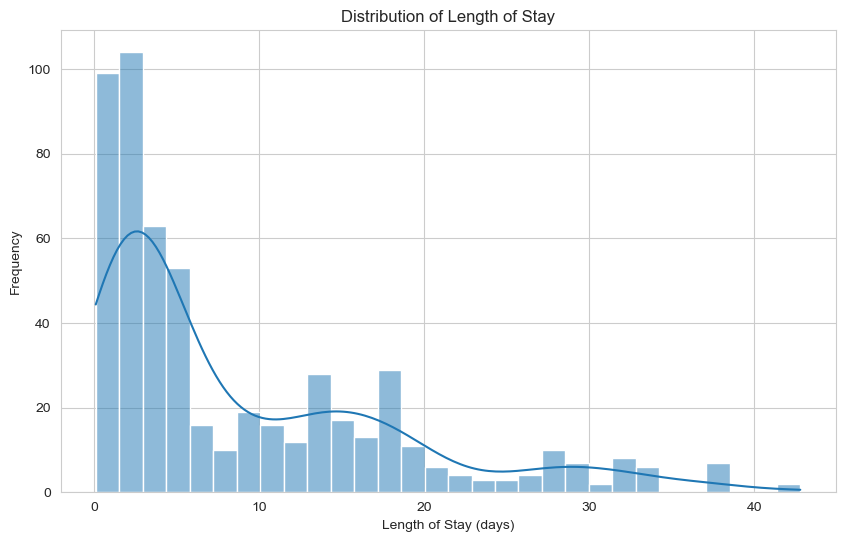

In [460]:
# Plot the distribution of the 'los' column to understand its range 
plt.figure(figsize=(10,6))
sns.histplot(ICU_FINAL['los'], kde=True, bins=30)
plt.title('Distribution of Length of Stay')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()

In [461]:
# Exploring the Categorical Variables 
categorical_columns = ICU_FINAL.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    print(f"Frequency of Categories in '{col}':")
    print(ICU_FINAL[col].value_counts(dropna=False))
    print("\n" + "-"*50 + "\n")

Frequency of Categories in 'icd_code':
80600    147
80605     98
80609     75
80604     63
80601     47
80608     42
80606     34
80603     23
80607     16
80602      7
Name: icd_code, dtype: int64

--------------------------------------------------

Frequency of Categories in 'long_title':
Closed fracture of C1-C4 level with unspecified spinal cord injury        147
Closed fracture of C5-C7 level with unspecified spinal cord injury         98
Closed fracture of C5-C7 level with other specified spinal cord injury     75
Closed fracture of C1-C4 level with other specified spinal cord injury     63
Closed fracture of C1-C4 level with complete lesion of cord                47
Closed fracture of C5-C7 level with central cord syndrome                  42
Closed fracture of C5-C7 level with complete lesion of cord                34
Closed fracture of C1-C4 level with central cord syndrome                  23
Closed fracture of C5-C7 level with anterior cord syndrome                 16
Closed

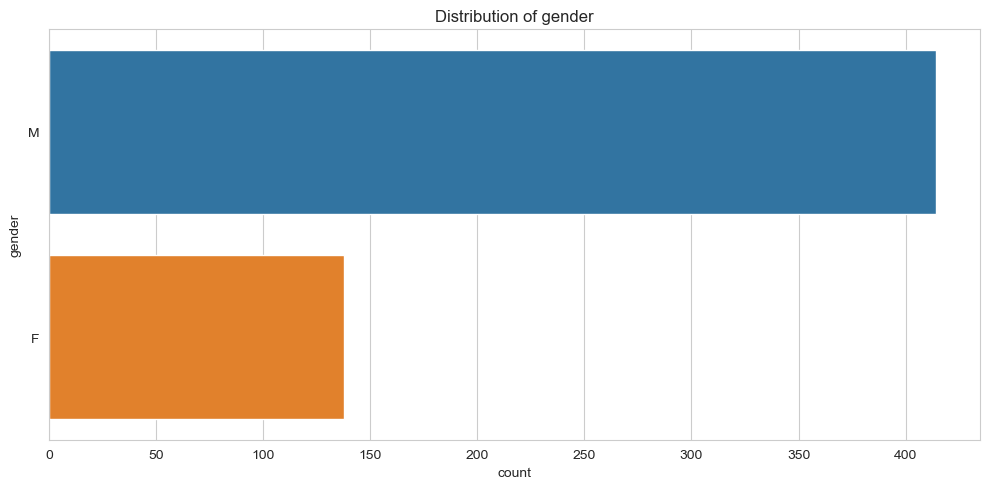

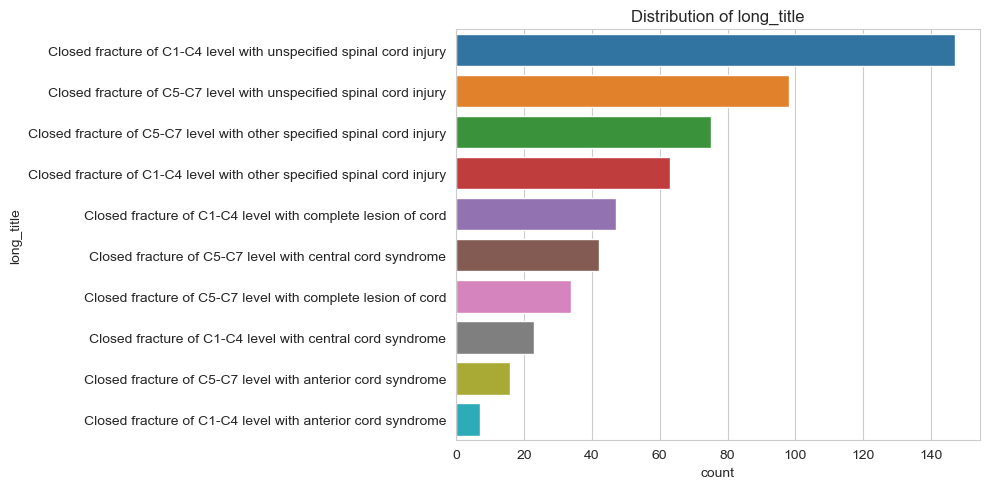

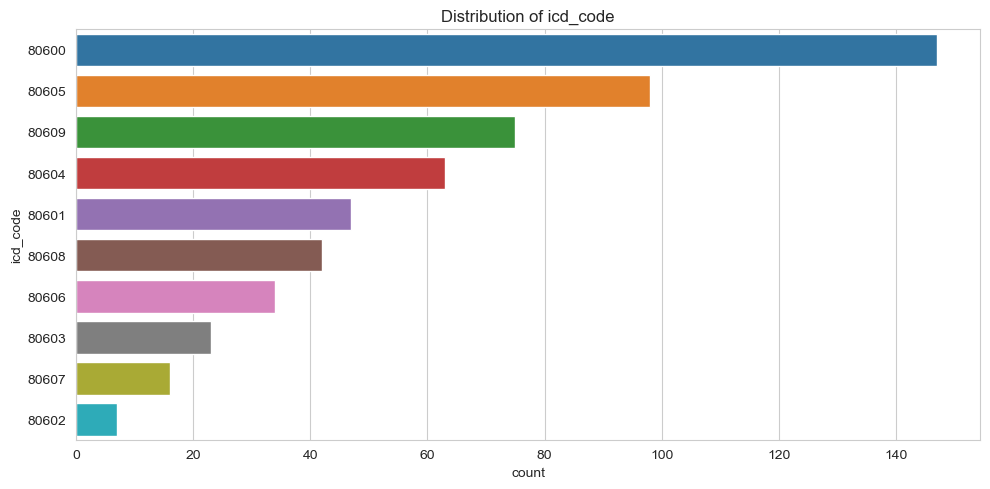

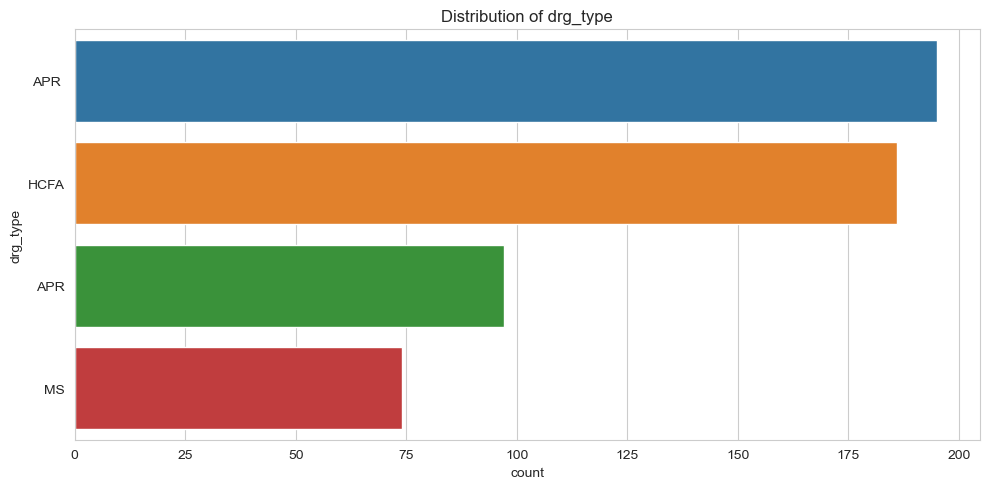

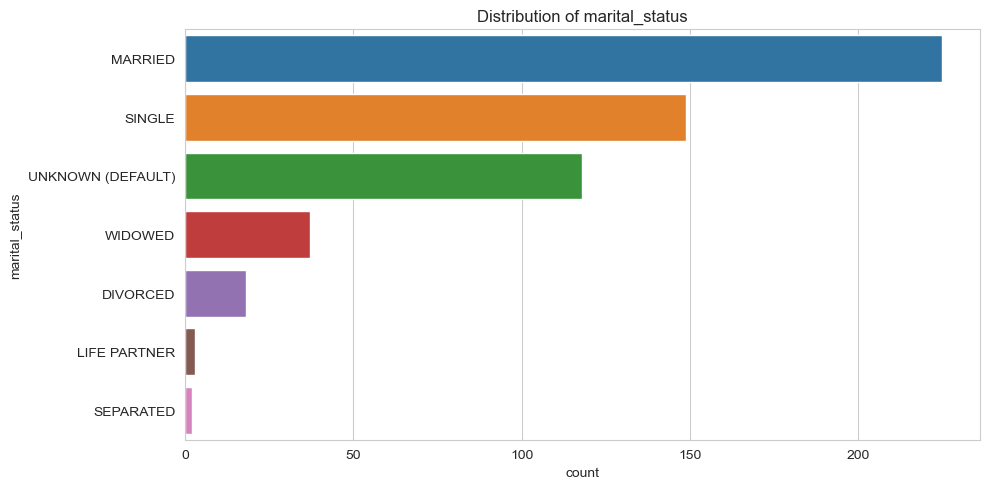

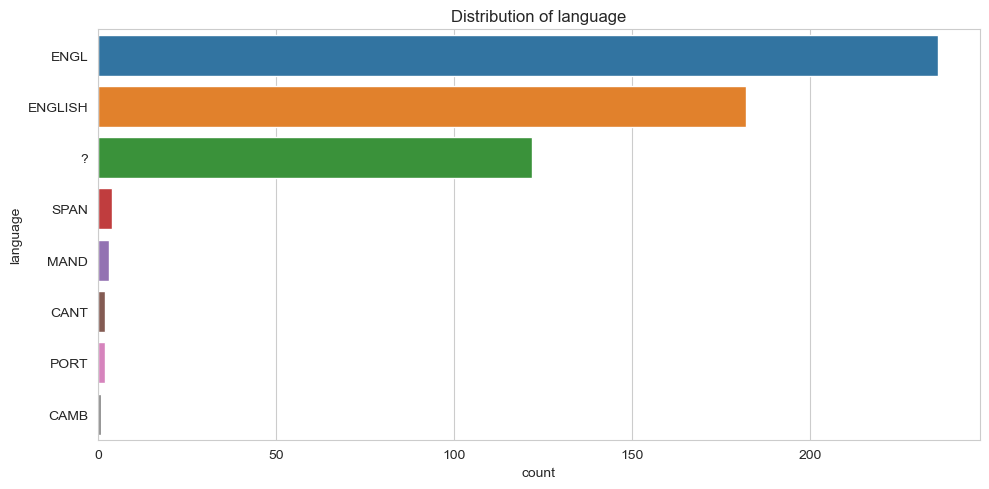

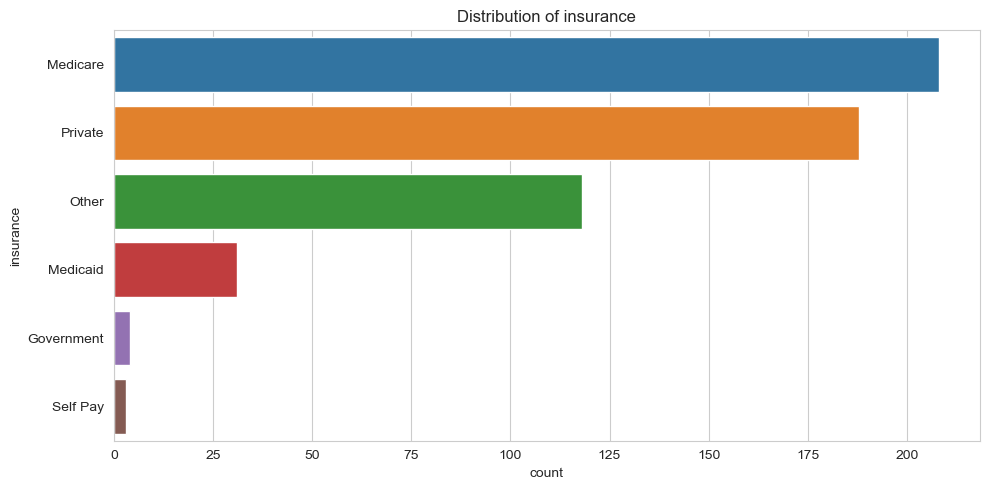

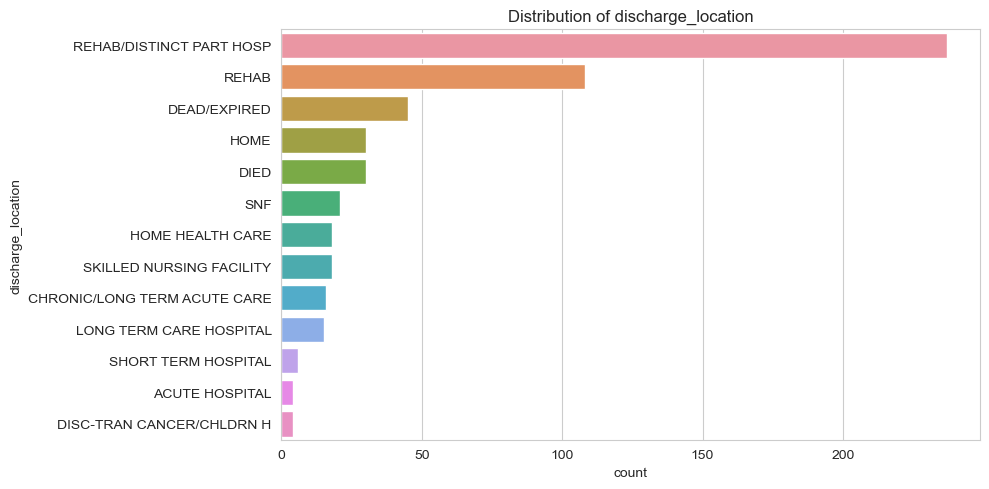

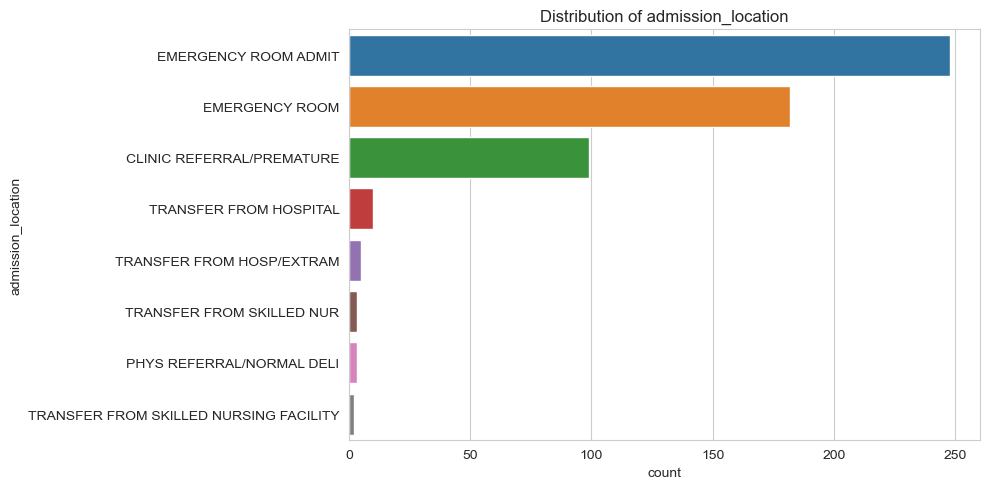

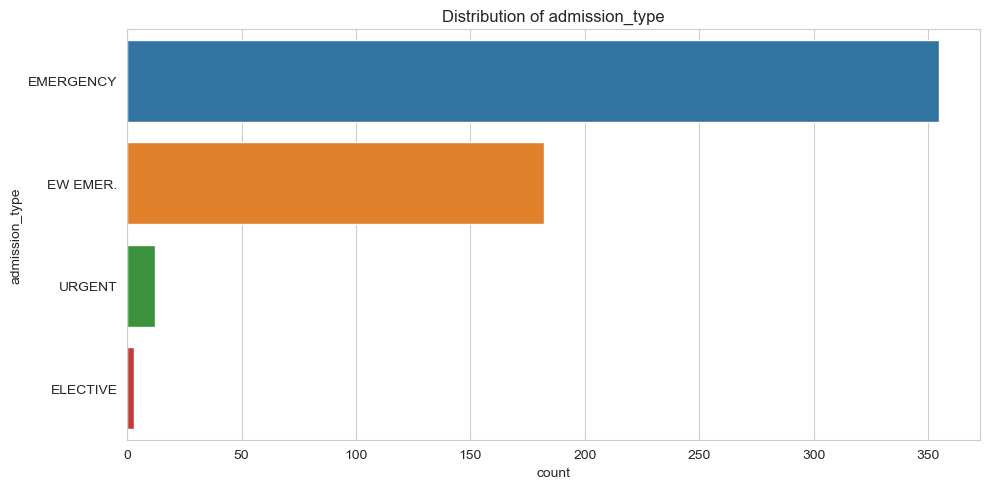

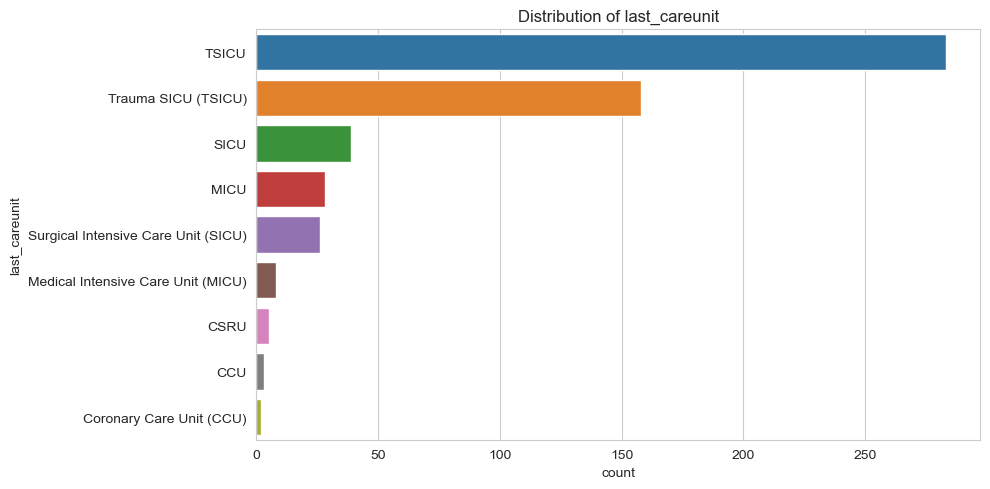

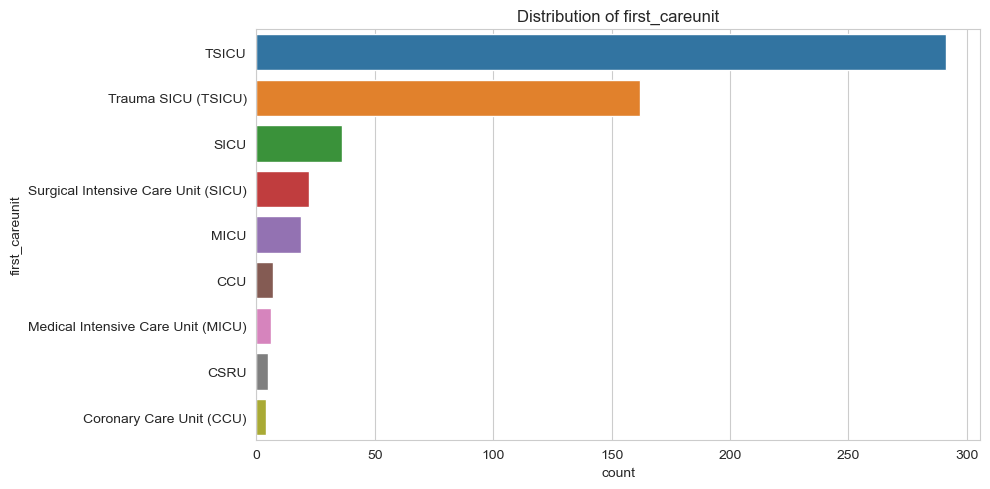

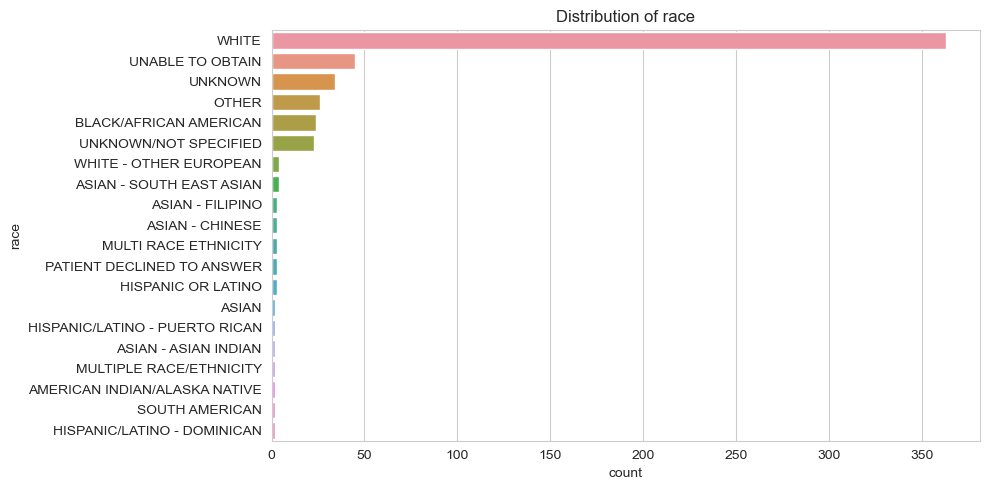

In [462]:
# Visualizing the categorical variables 
# List of specified categorical columns for which to make bar charts
specified_columns = [
    'gender', 'long_title', 'icd_code', 'drg_type', 'marital_status',
    'language', 'insurance', 'discharge_location', 'admission_location',
    'admission_type', 'last_careunit', 'first_careunit', 'race'
]

# Set the aesthetic style of the plots 
sns.set_style("whitegrid")

# Plot bar charts for the specified columns 
for col in specified_columns:
    plt.figure(figsize=(10,5))
    sns.countplot(y=ICU_FINAL[col], order=ICU_FINAL[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

<h2>Visual EDA to find Outliers and Correlations</h2>

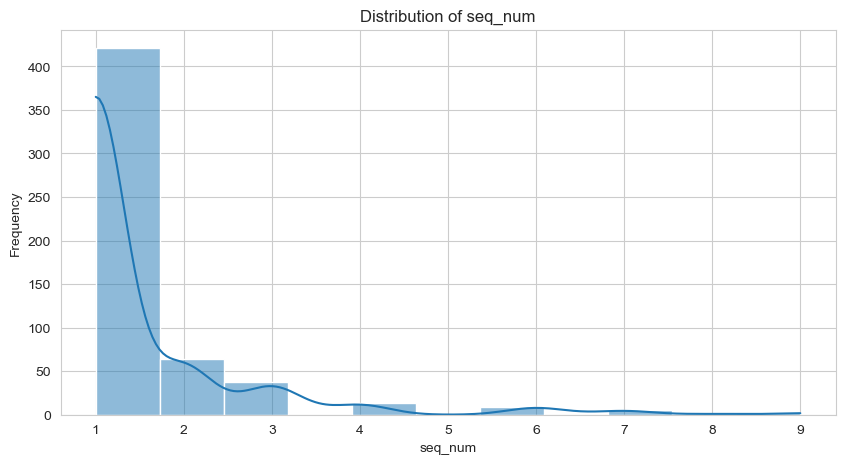

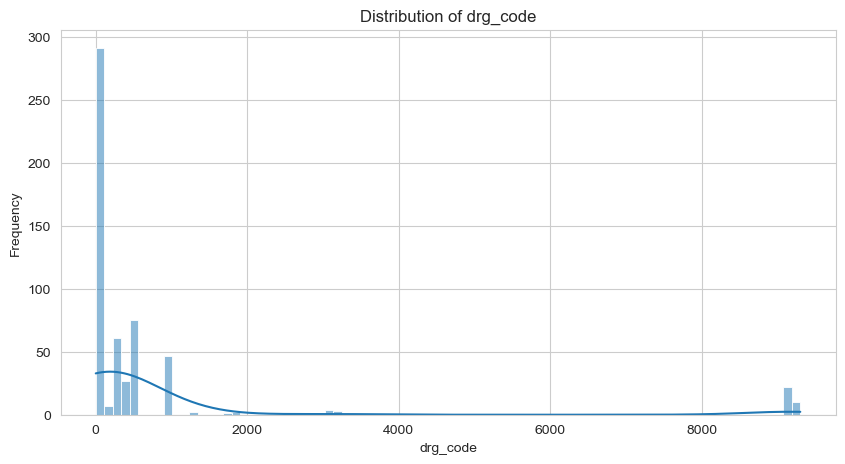

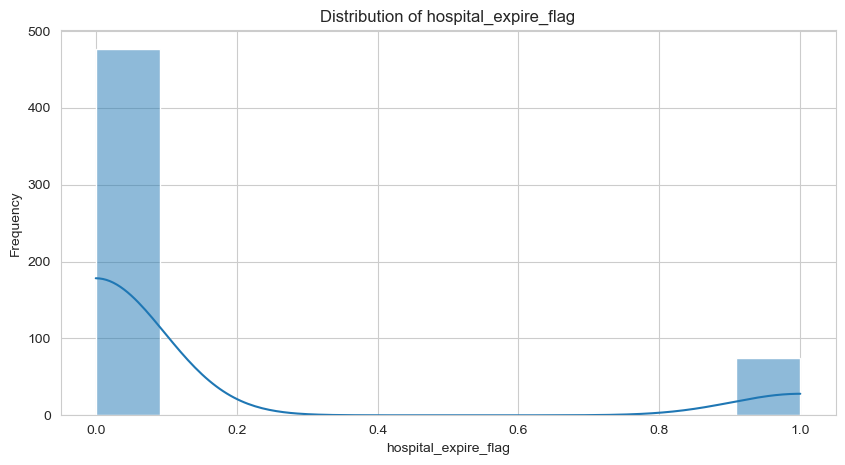

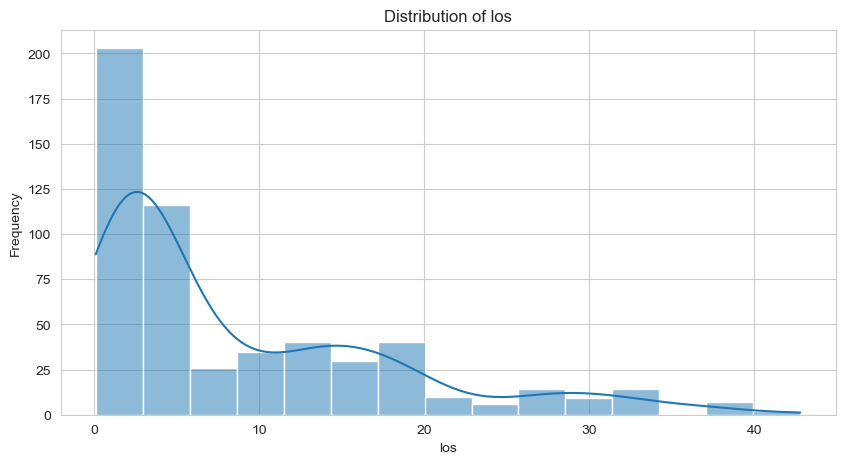

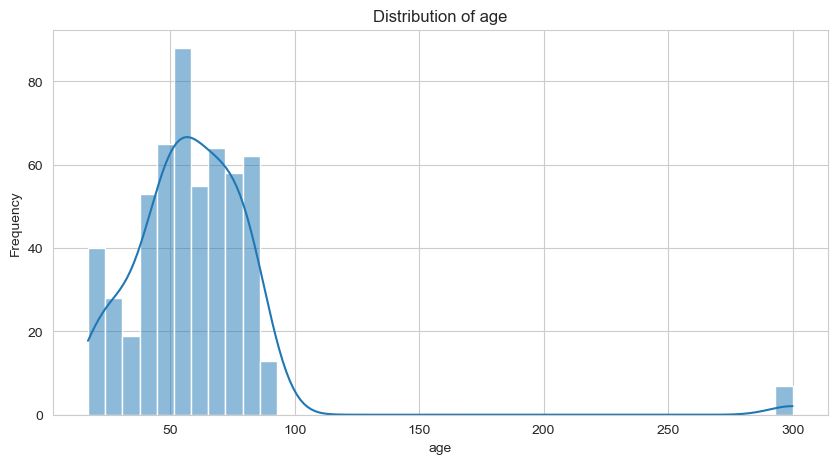

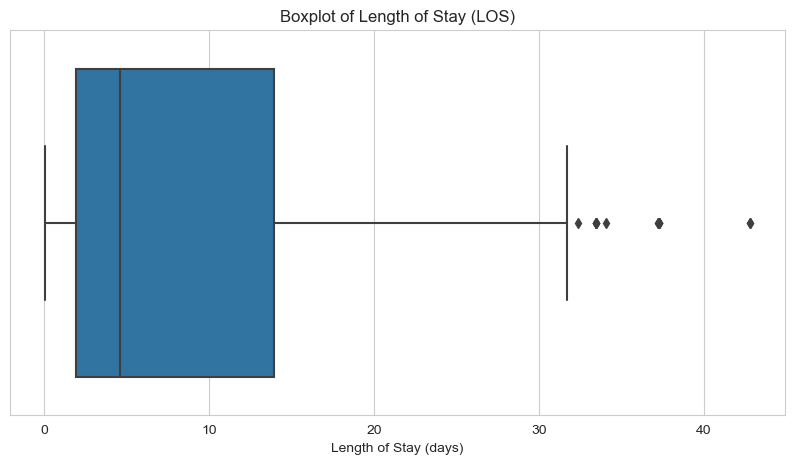

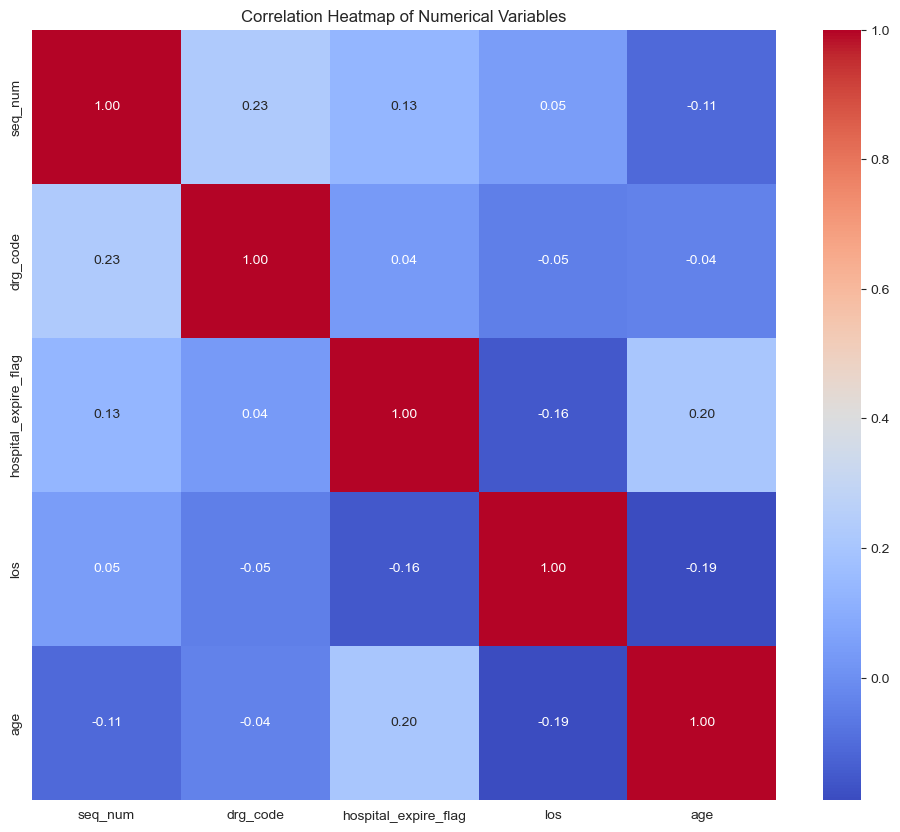

In [463]:
# List of numerical columns in the DataFrame (excluding 'subject_id', 'hadm_id', etc., if they are not meaningful for analysis)
numerical_columns = ICU_FINAL.select_dtypes(include=['float64', 'int64']).columns.tolist()
# Exclude ID-like columns if they are just identifiers, not actual numeric features
numerical_columns = [col for col in numerical_columns if col not in ('subject_id', 'hadm_id')]

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot histograms for numerical variables
for col in numerical_columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(ICU_FINAL[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Plot boxplots for numerical variables, focusing on 'los' for outlier detection
plt.figure(figsize=(10, 5))
sns.boxplot(x=ICU_FINAL['los'])
plt.title('Boxplot of Length of Stay (LOS)')
plt.xlabel('Length of Stay (days)')
plt.show()

# Plot a correlation heatmap for numerical variables
correlation_matrix = ICU_FINAL[numerical_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

<p>The heatmap is a visual representation of the correlation matrix for numerical variables within the dataset. Here's a breakdown of what the visual elements represent:</p>

<ul>
  <li><strong>Diagonal Squares (Red):</strong> These squares represent a perfect correlation of variables with themselves, which is always 1.00.</li>
  <li><strong>LOS and Hospital Expire Flag (Dark Blue Square):</strong> A moderate negative correlation (approximately -0.16) suggests that patients who expired tended to have a shorter LOS. Which makes sense.</li>
  <li><strong>LOS and Other Variables (Light Blue Squares):</strong> The very weak correlation of LOS with DRG Code and Seq_Num indicates a lack of a linear relationship.</li>
  <li><strong>Hospital Expire Flag and Seq_Num (Light Blue Square):</strong> A weak positive correlation (approximately 0.13) is observed, suggesting a slight association.</li>
  <li><strong>DRG Code and Seq_Num (Light Blue Square):</strong> A weak positive correlation (approximately 0.23) could indicate a marginal relationship where higher sequence numbers associate with certain DRG codes.</li>
</ul>

<h1>Feature Engineering</h1>
<p>
    From the EDA we can see that we can simplify the categorical variables further by creating more generalized sets, so let's do that.
</p>

In [464]:
# Replace one variant of 'APR' with another to merge them into a single category
ICU_FINAL['drg_type'] = ICU_FINAL['drg_type'].replace({'APR': 'APR', 'APR ': 'APR'}).str.strip()

# Now, 'APR' and 'APR ' (with any trailing spaces) are merged into 'APR', and any accidental leading/trailing spaces are removed from all entries
# Verify the result
ICU_FINAL['drg_type'].value_counts()

APR     292
HCFA    186
MS       74
Name: drg_type, dtype: int64

In [465]:
# Group 'DIVORCED' and 'SEPARATED' categories together as 'DIVORCED' and rename 'UNKNOWN (DEFAULT)'
ICU_FINAL['marital_status'] = ICU_FINAL['marital_status'].replace({
    'SEPARATED': 'DIVORCED',
    'UNKNOWN (DEFAULT)': 'UNKNOWN'
})

# Verify the result
ICU_FINAL['marital_status'].value_counts()

MARRIED         225
SINGLE          149
UNKNOWN         118
WIDOWED          37
DIVORCED         20
LIFE PARTNER      3
Name: marital_status, dtype: int64

In [466]:
# Replace 'ENGL' with 'ENGLISH' and '?' with 'UNKNOWN' in the 'language' column
ICU_FINAL['language'] = ICU_FINAL['language'].replace({'ENGL': 'ENGLISH', '?': 'UNKNOWN'})

# Verify the result
ICU_FINAL['language'].value_counts()

ENGLISH    418
UNKNOWN    122
SPAN         4
MAND         3
CANT         2
PORT         2
CAMB         1
Name: language, dtype: int64

In [467]:
# Replace 'Self Pay' and 'Government' with 'Other'
ICU_FINAL['insurance'] = ICU_FINAL['insurance'].replace({'Self Pay': 'Other', 'Government':'Other'})

ICU_FINAL['insurance'].value_counts()

Medicare    208
Private     188
Other       125
Medicaid     31
Name: insurance, dtype: int64

In [468]:
# Define a mapping for grouping categories
group_mapping = {
    'REHAB/DISTINCT PART HOSP': 'REHABILITATION',
    'REHAB': 'REHABILITATION',
    'DEAD/EXPIRED': 'DECEASED',
    'DIED': 'DECEASED',
    'SNF': 'LONG-TERM CARE/SKILLED NURSING',
    'SKILLED NURSING FACILITY': 'LONG-TERM CARE/SKILLED NURSING',
    'CHRONIC/LONG TERM ACUTE CARE': 'LONG-TERM CARE/SKILLED NURSING',
    'LONG TERM CARE HOSPITAL': 'LONG-TERM CARE/SKILLED NURSING',
    'HOME HEALTH CARE': 'HOME',
    'SHORT TERM HOSPITAL': 'ACUTE HOSPITAL',
    # Note: 'DISC-TRAN CANCER/CHLDRN H' is left as is due to its specificity
}

# Apply the grouping
ICU_FINAL['discharge_location'] = ICU_FINAL['discharge_location'].replace(group_mapping)

# Verify the result
ICU_FINAL['discharge_location'].value_counts()

REHABILITATION                    345
DECEASED                           75
LONG-TERM CARE/SKILLED NURSING     70
HOME                               48
ACUTE HOSPITAL                     10
DISC-TRAN CANCER/CHLDRN H           4
Name: discharge_location, dtype: int64

In [469]:
# Define a mapping for grouping categories
admission_group_mapping = {
    'EMERGENCY ROOM ADMIT': 'EMERGENCY ROOM',
    'TRANSFER FROM HOSP/EXTRAM': 'TRANSFER FROM HOSPITAL',
    'TRANSFER FROM SKILLED NUR': 'TRANSFER FROM SKILLED NURSING FACILITY',
    'CLINIC REFERRAL/PREMATURE': 'CLINIC REFERRAL',
    'PHYS REFERRAL/NORMAL DELI': 'CLINIC REFERRAL',
}

# Apply the grouping
ICU_FINAL['admission_location'] = ICU_FINAL['admission_location'].replace(admission_group_mapping)

# Verify the result
ICU_FINAL['admission_location'].value_counts()

EMERGENCY ROOM                            430
CLINIC REFERRAL                           102
TRANSFER FROM HOSPITAL                     15
TRANSFER FROM SKILLED NURSING FACILITY      5
Name: admission_location, dtype: int64

In [470]:
# Group 'EMERGENCY' and 'EW EMER.' into a single category 'EMERGENCY'
ICU_FINAL['admission_type'] = ICU_FINAL['admission_type'].replace({'EW EMER.': 'EMERGENCY'})
ICU_FINAL['admission_type'] = ICU_FINAL['admission_type'].replace({'URGENT': 'EMERGENCY'})

# Verify the result
ICU_FINAL['admission_type'].value_counts()

EMERGENCY    549
ELECTIVE       3
Name: admission_type, dtype: int64

In [471]:
# Define a mapping for grouping care unit categories
careunit_group_mapping = {
    'Trauma SICU (TSICU)': 'TSICU',
    'Surgical Intensive Care Unit (SICU)': 'SICU',
    'Medical Intensive Care Unit (MICU)': 'MICU',
    'Coronary Care Unit (CCU)': 'CCU'
}

# Apply the grouping
ICU_FINAL['last_careunit'] = ICU_FINAL['last_careunit'].replace(careunit_group_mapping)
ICU_FINAL['first_careunit'] = ICU_FINAL['first_careunit'].replace(careunit_group_mapping)

# Verify the result
print(ICU_FINAL['first_careunit'].value_counts())
print(ICU_FINAL['last_careunit'].value_counts())

TSICU    453
SICU      58
MICU      25
CCU       11
CSRU       5
Name: first_careunit, dtype: int64
TSICU    441
SICU      65
MICU      36
CCU        5
CSRU       5
Name: last_careunit, dtype: int64


In [472]:
# Define a mapping for grouping race categories
race_group_mapping = {
    'ASIAN - SOUTH EAST ASIAN': 'ASIAN',
    'ASIAN - FILIPINO': 'ASIAN',
    'ASIAN - CHINESE': 'ASIAN',
    'ASIAN - ASIAN INDIAN': 'ASIAN',
    'MULTI RACE ETHNICITY': 'MULTIPLE RACE/ETHNICITY',
    'HISPANIC/LATINO - PUERTO RICAN': 'HISPANIC OR LATINO',
    'HISPANIC/LATINO - DOMINICAN': 'HISPANIC OR LATINO',
    'SOUTH AMERICAN': 'HISPANIC OR LATINO',
    'UNABLE TO OBTAIN': 'UNKNOWN',
    'UNKNOWN/NOT SPECIFIED': 'UNKNOWN',
    'PATIENT DECLINED TO ANSWER': 'OTHER'
}

# Apply the grouping
ICU_FINAL['race'] = ICU_FINAL['race'].replace(race_group_mapping)

# Verify the result
ICU_FINAL['race'].value_counts()

WHITE                            363
UNKNOWN                          102
OTHER                             29
BLACK/AFRICAN AMERICAN            24
ASIAN                             14
HISPANIC OR LATINO                 9
MULTIPLE RACE/ETHNICITY            5
WHITE - OTHER EUROPEAN             4
AMERICAN INDIAN/ALASKA NATIVE      2
Name: race, dtype: int64

In [473]:
# From the box plot and the distribution of the LOS we see there are several outliers
# Calculate the IQR (Interquartile Range)
Q1 = ICU_FINAL['los'].quantile(0.25)
Q3 = ICU_FINAL['los'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_ICU_FINAL = ICU_FINAL[(ICU_FINAL['los'] >= lower_bound) & (ICU_FINAL['los'] <= upper_bound)]

In [474]:
filtered_ICU_FINAL.shape

(536, 29)

In [475]:
filtered_ICU_FINAL.describe()

,subject_id,hadm_id,seq_num,drg_code,hospital_expire_flag,los,age,edregtime_missing,edouttime_missing
count,5.360000e+02,5.360000e+02,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000
mean,5.411670e+06,8.911909e+06,1.483209,801.464552,0.136194,8.040296,60.667910,0.035448,0.035448
std,7.502313e+06,1.207772e+07,1.108884,2125.387244,0.343315,8.006322,33.137575,0.185081,0.185081
min,1.750000e+02,1.005630e+05,1.000000,1.000000,0.000000,0.078368,17.000000,0.000000,0.000000
25%,2.510800e+04,1.388158e+05,1.000000,26.000000,0.000000,1.897000,46.000000,0.000000,0.000000
50%,7.016900e+04,1.746000e+05,1.000000,53.000000,0.000000,4.497400,58.000000,0.000000,0.000000
75%,1.345536e+07,2.258193e+07,1.000000,487.000000,0.000000,13.699701,73.250000,0.000000,0.000000
max,1.997095e+07,2.989790e+07,8.000000,9304.000000,1.000000,31.686500,300.000000,1.000000,1.000000


In [476]:
# next we need to change all ages above 88 to 89
filtered_ICU_FINAL['age'] = filtered_ICU_FINAL['age'].apply(lambda x: 89 if x > 88 else x)

# Check the result to ensure ages above 88 have been converted to 89
filtered_ICU_FINAL['age'].unique()


C:\Users\Karuna\AppData\Local\Temp\ipykernel_16888\418376116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ICU_FINAL['age'] = filtered_ICU_FINAL['age'].apply(lambda x: 89 if x > 88 else x)


array([71, 58, 48, 55, 85, 63, 52, 39, 79, 74, 24, 38, 77, 61, 65, 80, 51,
       57, 70, 60, 86, 67, 72, 87, 25, 66, 62, 44, 78, 23, 46, 20, 75, 50,
       69, 22, 81, 84, 56, 54, 76, 53, 45, 82, 68, 59, 35, 89, 27, 18, 17,
       83, 49, 29, 40, 41, 42, 19, 36, 47, 73, 32, 21, 37, 43, 88, 33, 34],
      dtype=int64)

In [477]:
# Convert columns to datetime
filtered_ICU_FINAL['admittime'] = pd.to_datetime(filtered_ICU_FINAL['admittime'])
filtered_ICU_FINAL['dischtime'] = pd.to_datetime(filtered_ICU_FINAL['dischtime'])
filtered_ICU_FINAL['intime'] = pd.to_datetime(filtered_ICU_FINAL['intime'])
filtered_ICU_FINAL['outtime'] = pd.to_datetime(filtered_ICU_FINAL['outtime'])
filtered_ICU_FINAL['edregtime'] = pd.to_datetime(filtered_ICU_FINAL['edregtime'], errors='coerce') # errors='coerce' to handle 'NA' values
filtered_ICU_FINAL['edouttime'] = pd.to_datetime(filtered_ICU_FINAL['edouttime'], errors='coerce')

# Calculate durations (days)
filtered_ICU_FINAL['hospital_stay_duration'] = (filtered_ICU_FINAL['dischtime'] - filtered_ICU_FINAL['admittime']).dt.total_seconds() / (24 * 3600)
filtered_ICU_FINAL['icu_stay_duration'] = (filtered_ICU_FINAL['outtime'] - filtered_ICU_FINAL['intime']).dt.total_seconds() / (24 * 3600)

# Handle possible NaT values by replacing them with a difference of zeros if any (hours)
filtered_ICU_FINAL['ed_duration'] = (filtered_ICU_FINAL['edouttime'] - filtered_ICU_FINAL['edregtime']).dt.total_seconds().fillna(0) / 3600

# Now we have three new columns with the duration in days
# Display the head of the DataFrame to check the new columns
filtered_ICU_FINAL[['hospital_stay_duration', 'icu_stay_duration', 'ed_duration']].head()

C:\Users\Karuna\AppData\Local\Temp\ipykernel_16888\2238437978.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ICU_FINAL['admittime'] = pd.to_datetime(filtered_ICU_FINAL['admittime'])
C:\Users\Karuna\AppData\Local\Temp\ipykernel_16888\2238437978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ICU_FINAL['dischtime'] = pd.to_datetime(filtered_ICU_FINAL['dischtime'])
C:\Users\Karuna\AppData\Local\Temp\ipykernel_16888\2238437978.py:4: SettingWithCopyWarning: 
A value is trying to be set

,hospital_stay_duration,icu_stay_duration,ed_duration
0,4.175694,2.301308,10.966667
1,4.175694,2.301308,10.966667
2,6.770139,1.893750,6.200000
3,6.770139,1.893750,6.200000
4,17.415972,17.376539,6.400000


In [478]:
filtered_ICU_FINAL.head()

,subject_id,hadm_id,seq_num,icd_code,long_title,gender,drg_type,drg_code,description,admittime,...,last_careunit,intime,outtime,los,age,edregtime_missing,edouttime_missing,hospital_stay_duration,icu_stay_duration,ed_duration
0,10196368,24464472,1.0,80604,Closed fracture of C1-C4 level with other spec...,M,APR,40,SPINAL DISORDERS & INJURIES,2184-05-03 13:50:00,...,TSICU,2184-05-03 14:36:00,2184-05-05 21:49:53,2.301308,71,0,0,4.175694,2.301308,10.966667
1,10196368,24464472,1.0,80604,Closed fracture of C1-C4 level with other spec...,M,HCFA,26,CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDU...,2184-05-03 13:50:00,...,TSICU,2184-05-03 14:36:00,2184-05-05 21:49:53,2.301308,71,0,0,4.175694,2.301308,10.966667
2,10348324,27926100,1.0,80608,Closed fracture of C5-C7 level with central co...,F,APR,23,SPINAL PROCEDURES,2137-06-29 20:21:00,...,TSICU,2137-07-02 01:42:38,2137-07-03 23:09:38,1.893750,58,0,0,6.770139,1.893750,6.200000
3,10348324,27926100,1.0,80608,Closed fracture of C5-C7 level with central co...,F,HCFA,26,CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDU...,2137-06-29 20:21:00,...,TSICU,2137-07-02 01:42:38,2137-07-03 23:09:38,1.893750,58,0,0,6.770139,1.893750,6.200000
4,10393331,21425859,1.0,80600,Closed fracture of C1-C4 level with unspecifie...,M,APR,4,TRACHEOSTOMY W MV 96+ HOURS W EXTENSIVE PROCEDURE,2114-03-27 00:01:00,...,TSICU,2114-03-27 01:30:00,2114-04-13 10:32:13,17.376539,48,0,0,17.415972,17.376539,6.400000


In [479]:
# Exploring the Categorical Variables 
categorical_columns = filtered_ICU_FINAL.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    print(f"Frequency of Categories in '{col}':")
    print(filtered_ICU_FINAL[col].value_counts(dropna=False))
    print("\n" + "-"*50 + "\n")

Frequency of Categories in 'icd_code':
80600    147
80605     93
80609     72
80604     62
80601     45
80608     42
80606     29
80603     23
80607     16
80602      7
Name: icd_code, dtype: int64

--------------------------------------------------

Frequency of Categories in 'long_title':
Closed fracture of C1-C4 level with unspecified spinal cord injury        147
Closed fracture of C5-C7 level with unspecified spinal cord injury         93
Closed fracture of C5-C7 level with other specified spinal cord injury     72
Closed fracture of C1-C4 level with other specified spinal cord injury     62
Closed fracture of C1-C4 level with complete lesion of cord                45
Closed fracture of C5-C7 level with central cord syndrome                  42
Closed fracture of C5-C7 level with complete lesion of cord                29
Closed fracture of C1-C4 level with central cord syndrome                  23
Closed fracture of C5-C7 level with anterior cord syndrome                 16
Closed

In [480]:
# Copy the DataFrame to keep the original data unchanged
encoded_ICU_FINAL = filtered_ICU_FINAL.copy()

# 1. ICD Code: One-hot encoding
icd_dummies = pd.get_dummies(encoded_ICU_FINAL['icd_code'], prefix='icd')
encoded_ICU_FINAL = encoded_ICU_FINAL.drop('icd_code', axis=1).join(icd_dummies)

# 3. Gender: Binary encoding
encoded_ICU_FINAL['is_female'] = encoded_ICU_FINAL['gender'].map({'M': 0, 'F': 1})

# 4. DRG Type: One-hot encoding
drg_type_dummies = pd.get_dummies(encoded_ICU_FINAL['drg_type'], prefix='drg_type')
encoded_ICU_FINAL = encoded_ICU_FINAL.drop('drg_type', axis=1).join(drg_type_dummies)

# 5. Admission Type: Binary encoding
encoded_ICU_FINAL['is_emergency'] = encoded_ICU_FINAL['admission_type'].map({'EMERGENCY': 1, 'ELECTIVE': 0})

# 6. Admission Location: One-hot encoding
admission_location_dummies = pd.get_dummies(encoded_ICU_FINAL['admission_location'], prefix='admission_loc')
encoded_ICU_FINAL = encoded_ICU_FINAL.drop('admission_location', axis=1).join(admission_location_dummies)

# 7. Discharge Location: One-hot encoding
discharge_location_dummies = pd.get_dummies(encoded_ICU_FINAL['discharge_location'], prefix='discharge_loc')
encoded_ICU_FINAL = encoded_ICU_FINAL.drop('discharge_location', axis=1).join(discharge_location_dummies)

# 8. Insurance: One-hot encoding
insurance_dummies = pd.get_dummies(encoded_ICU_FINAL['insurance'], prefix='insurance')
encoded_ICU_FINAL = encoded_ICU_FINAL.drop('insurance', axis=1).join(insurance_dummies)

# 9. Language: One-hot encoding
language_dummies = pd.get_dummies(encoded_ICU_FINAL['language'], prefix='language')
encoded_ICU_FINAL = encoded_ICU_FINAL.drop('language', axis=1).join(language_dummies)

# 10. Marital Status: One-hot encoding
marital_status_dummies = pd.get_dummies(encoded_ICU_FINAL['marital_status'], prefix='marital_status')
encoded_ICU_FINAL = encoded_ICU_FINAL.drop('marital_status', axis=1).join(marital_status_dummies)

# 11. Race: One-hot encoding
race_dummies = pd.get_dummies(encoded_ICU_FINAL['race'], prefix='race')
encoded_ICU_FINAL = encoded_ICU_FINAL.drop('race', axis=1).join(race_dummies)

# 12. First Care Unit: One-hot encoding
first_careunit_dummies = pd.get_dummies(encoded_ICU_FINAL['first_careunit'], prefix='first_careunit')
encoded_ICU_FINAL = encoded_ICU_FINAL.drop('first_careunit', axis=1).join(first_careunit_dummies)

# 13. Last Care Unit: One-hot encoding
last_careunit_dummies = pd.get_dummies(encoded_ICU_FINAL['last_careunit'], prefix='last_careunit')
encoded_ICU_FINAL = encoded_ICU_FINAL.drop('last_careunit', axis=1).join(last_careunit_dummies)


# Verifying the result
print(encoded_ICU_FINAL.head()) # Just to confirm the encoding



   subject_id   hadm_id  seq_num  \
0    10196368  24464472      1.0   
1    10196368  24464472      1.0   
2    10348324  27926100      1.0   
3    10348324  27926100      1.0   
4    10393331  21425859      1.0   

                                          long_title gender  drg_code  \
0  Closed fracture of C1-C4 level with other spec...      M        40   
1  Closed fracture of C1-C4 level with other spec...      M        26   
2  Closed fracture of C5-C7 level with central co...      F        23   
3  Closed fracture of C5-C7 level with central co...      F        26   
4  Closed fracture of C1-C4 level with unspecifie...      M         4   

                                         description           admittime  \
0                        SPINAL DISORDERS & INJURIES 2184-05-03 13:50:00   
1  CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDU... 2184-05-03 13:50:00   
2                                  SPINAL PROCEDURES 2137-06-29 20:21:00   
3  CRANIOTOMY & ENDOVASCULAR INTRACRANIA

In [481]:
print(encoded_ICU_FINAL.columns)

Index(['subject_id', 'hadm_id', 'seq_num', 'long_title', 'gender', 'drg_code',
       'description', 'admittime', 'dischtime', 'admission_type', 'edregtime',
       'edouttime', 'hospital_expire_flag', 'intime', 'outtime', 'los', 'age',
       'edregtime_missing', 'edouttime_missing', 'hospital_stay_duration',
       'icu_stay_duration', 'ed_duration', 'icd_80600', 'icd_80601',
       'icd_80602', 'icd_80603', 'icd_80604', 'icd_80605', 'icd_80606',
       'icd_80607', 'icd_80608', 'icd_80609', 'is_female', 'drg_type_APR',
       'drg_type_HCFA', 'drg_type_MS', 'is_emergency',
       'admission_loc_CLINIC REFERRAL', 'admission_loc_EMERGENCY ROOM',
       'admission_loc_TRANSFER FROM HOSPITAL',
       'admission_loc_TRANSFER FROM SKILLED NURSING FACILITY',
       'discharge_loc_ACUTE HOSPITAL', 'discharge_loc_DECEASED',
       'discharge_loc_DISC-TRAN CANCER/CHLDRN H', 'discharge_loc_HOME',
       'discharge_loc_LONG-TERM CARE/SKILLED NURSING',
       'discharge_loc_REHABILITATION', 'ins

In [482]:
encoded_ICU_FINAL.drop('gender', axis=1, inplace=True)


In [483]:
# I will also remove the description column, since we have already encoded the long title column 
encoded_ICU_FINAL.drop('description', axis = 1, inplace=True)

In [484]:
# List of datetime columns to drop
datetime_columns_to_drop = ['admittime', 'dischtime', 'intime', 'outtime', 'edregtime', 'edouttime']

# Drop the datetime columns
encoded_ICU_FINAL.drop(datetime_columns_to_drop, axis=1, inplace=True)

In [485]:
encoded_ICU_FINAL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536 entries, 0 to 551
Data columns (total 75 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   subject_id                                            536 non-null    int64  
 1   hadm_id                                               536 non-null    int64  
 2   seq_num                                               536 non-null    float64
 3   long_title                                            536 non-null    object 
 4   drg_code                                              536 non-null    int64  
 5   admission_type                                        536 non-null    object 
 6   hospital_expire_flag                                  536 non-null    int64  
 7   los                                                   536 non-null    float64
 8   age                                                   536 no

In [486]:
print(encoded_ICU_FINAL['long_title'].value_counts())

Closed fracture of C1-C4 level with unspecified spinal cord injury        147
Closed fracture of C5-C7 level with unspecified spinal cord injury         93
Closed fracture of C5-C7 level with other specified spinal cord injury     72
Closed fracture of C1-C4 level with other specified spinal cord injury     62
Closed fracture of C1-C4 level with complete lesion of cord                45
Closed fracture of C5-C7 level with central cord syndrome                  42
Closed fracture of C5-C7 level with complete lesion of cord                29
Closed fracture of C1-C4 level with central cord syndrome                  23
Closed fracture of C5-C7 level with anterior cord syndrome                 16
Closed fracture of C1-C4 level with anterior cord syndrome                  7
Name: long_title, dtype: int64


In [487]:
# Initialize the TF-IDF Vectorizer with English stopwords and a suitable max_features
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=50)  # Adjust max_features based on your needs

# Fit and transform the 'long_title' column
tfidf_matrix = tfidf_vectorizer.fit_transform(encoded_ICU_FINAL['long_title'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Concatenate the TF-IDF DataFrame with the original DataFrame
# Ensure indices align between encoded_ICU_FINAL and tfidf_df if encoded_ICU_FINAL has been modified prior
encoded_ICU_FINAL = pd.concat([encoded_ICU_FINAL.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

# Optionally, drop the original 'long_title' column if it's no longer needed
encoded_ICU_FINAL.drop('long_title', axis=1, inplace=True)

In [488]:
encoded_ICU_FINAL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 91 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   subject_id                                            536 non-null    int64  
 1   hadm_id                                               536 non-null    int64  
 2   seq_num                                               536 non-null    float64
 3   drg_code                                              536 non-null    int64  
 4   admission_type                                        536 non-null    object 
 5   hospital_expire_flag                                  536 non-null    int64  
 6   los                                                   536 non-null    float64
 7   age                                                   536 non-null    int64  
 8   edregtime_missing                                     536 no

In [489]:
# Drop the admission_type column
encoded_ICU_FINAL.drop('admission_type', axis=1, inplace=True)

In [490]:
# Assuming 'encoded_ICU_FINAL' is your DataFrame and 'los' is the target variable
X = encoded_ICU_FINAL.drop(columns=['los', 'icu_stay_duration'], axis=1)  # Features
y = encoded_ICU_FINAL['los']  # Target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of numerical features to scale
numerical_features = ['seq_num', 'drg_code', 'age', 'hospital_stay_duration',
                    'ed_duration'] + [f for f in X.columns if f.startswith('ant') or f.startswith('c') or f in ['central', 'closed', 'complete', 'cord', 'fracture', 'injury', 'lesion', 'level', 'specified', 'spinal', 'syndrome', 'unspecified']]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training set
scaler.fit(X_train[numerical_features])

# Transform both the training set and the test set
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [491]:
# For X_train
nan_columns_train = X_train.columns[X_train.isna().any()].tolist()
print("Columns with NaN values in X_train:", nan_columns_train)

# For X_test
nan_columns_test = X_test.columns[X_test.isna().any()].tolist()
print("Columns with NaN values in X_test:", nan_columns_test)

Columns with NaN values in X_train: []
Columns with NaN values in X_test: []


In [492]:
X_train['drg_code'].value_counts(dropna=False)

-0.285067    38
-0.370586    38
-0.389137    33
-0.145704    26
-0.380088    24
             ..
 0.376003     1
-0.166066     1
 0.039359     1
-0.319456     1
-0.376920     1
Name: drg_code, Length: 67, dtype: int64

# Model Selection

In [493]:
def test_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression (Multi)': LinearRegression(),
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'Random Forest': RandomForestRegressor(),
        'Gradient Boosting': GradientBoostingRegressor()
    }
    
    results = {}
    
    for name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate RMSE and R^2
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r_squared = r2_score(y_test, y_pred)
        
        # Store the results
        results[name] = {'RMSE': rmse, 'R^2': r_squared}
        
        # Print the results
        print(f"{name}: RMSE = {rmse:.2f}, R^2 = {r_squared:.2f}")
        
    return results

# Run the test function with your dataset
results = test_models(X_train, X_test, y_train, y_test)

Linear Regression (Multi): RMSE = 6.19, R^2 = 0.46
Ridge Regression: RMSE = 6.06, R^2 = 0.48
Lasso Regression: RMSE = 6.87, R^2 = 0.33


c:\Users\Karuna\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.47253e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Random Forest: RMSE = 2.79, R^2 = 0.89
Gradient Boosting: RMSE = 3.41, R^2 = 0.84


In [494]:
from sklearn.model_selection import GridSearchCV

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor()

# Define the grid of parameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)

print(f"Optimized Gradient Boosting: RMSE = {rmse:.2f}, R^2 = {r_squared:.2f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits


Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Optimized Gradient Boosting: RMSE = 2.76, R^2 = 0.89


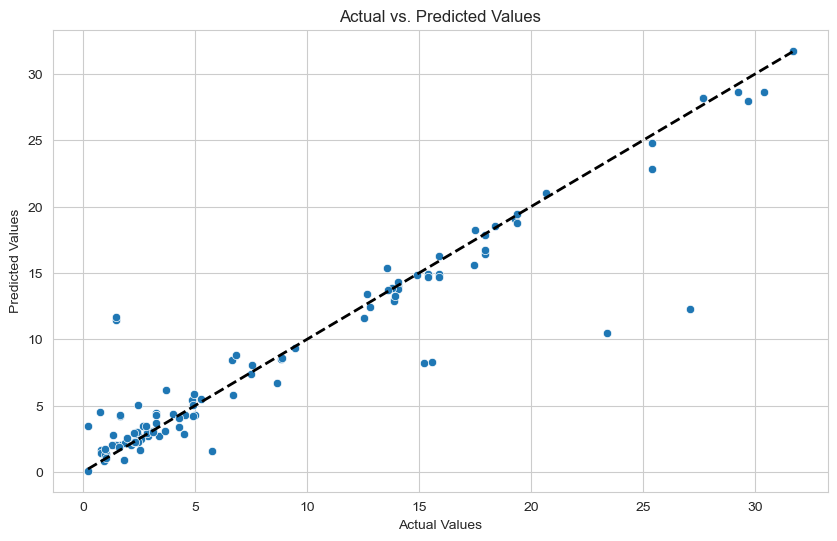

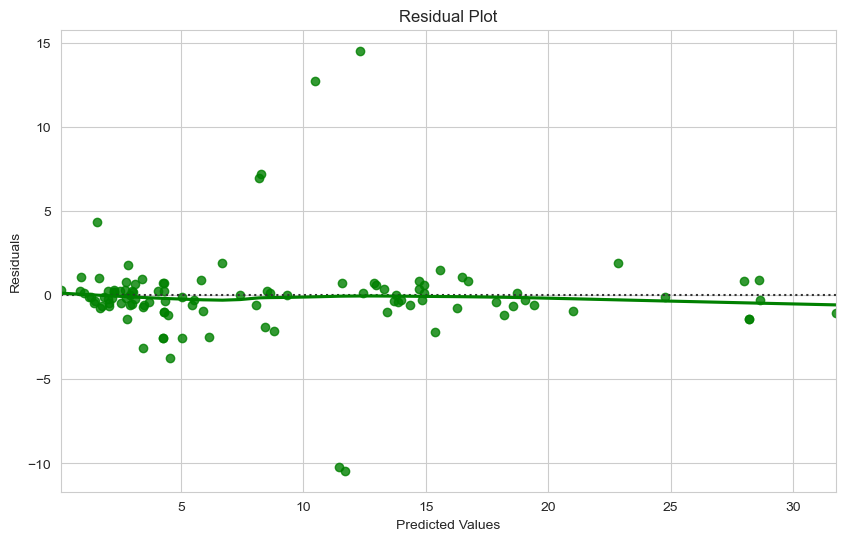

In [495]:
# 1. Scatter Plot of Actual vs. Predicted Values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for reference
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

# 2. Residual Plot
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=y_test - y_pred, lowess=True, color="g")
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

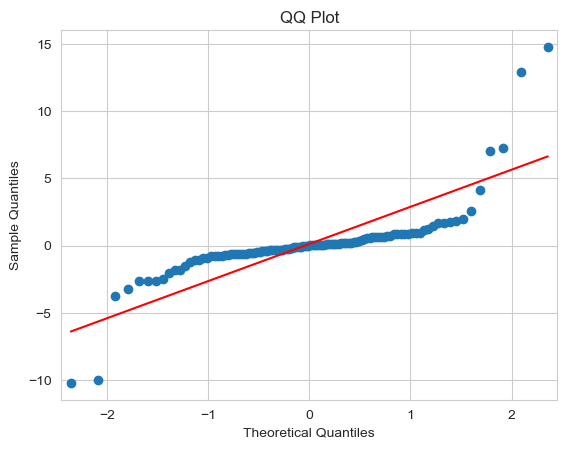

In [496]:
from statsmodels.graphics.gofplots import qqplot

# QQ Plot
residuals = y_test - y_pred
qqplot(residuals, line='s')
plt.title('QQ Plot')
plt.show()

## Model Evaluation Based on Plots

### Actual vs. Predicted Values Plot


The plot shows a strong alignment of the predicted values with the actual values, as most data points closely follow the diagonal line. This indicates that the model has a high degree of accuracy.

### Residual Plot


The residuals are mostly scattered around the zero line, which implies that the variance is constant (homoscedasticity), and there are no obvious patterns. This suggests that the model does well for most of the range but there may be some instances of over or under-prediction, as evidenced by a few points with higher residuals.

### QQ Plot


The QQ plot shows how well the distribution of residuals fits the normal distribution. The points largely follow the red line, especially in the center of the distribution, but there are some deviations at the ends. This indicates that while the residuals are mostly normally distributed, there are some outliers or extremes which could be potential leverage points or indications of non-linearity.

## Conclusion
The Gradient Boosting Regressor, with parameters `{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}`, achieves an RMSE of 2.76 and an R^2 of 0.89. Based on the plots, the model shows a strong predictive performance with residuals that are fairly normally distributed, but some attention may be needed for extreme values or outliers.
